In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import pickle
import seaborn as sns
import statsmodels.api as sm
import sys
from statsmodels.formula.api import ols
import shap
import pylab as py
import scipy.stats as stats
from all_houses_exported_functions import *
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, RepeatedKFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PolynomialFeatures, FunctionTransformer
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.decomposition import PCA, KernelPCA
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, RANSACRegressor, ElasticNetCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, BaggingRegressor, VotingRegressor, StackingRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score 

In [3]:
from sklearn import set_config
set_config(display="diagram")

##### Abstract

The project is devoted to the houses for sale in Bulgaria right now. We use the file 'alo_13-16_10_November_2022.csv'. It is a result of web crawling between the 10th and 12th of November. Its source is https://www.alo.bg/ 

The spider gathered information from different listings about the price, size of the home, size of the yard, number of floors, location, and whether some advantages are explicitly mentioned like solar panels, fireplace, pool, etc.

One more column is used in order to get information about the income of people by region. Its source is The Bulgarian National Statistical Institute.

The price as a dependent variable is typical for this kind of project. It is our target as well. The goal of this notebook, though, is to help people find the best offers and the right time for buying a house.

#### Performance Metrics

The average price is something that people often use when comparing properties. We want to see the degree of our model performance over that of the average price. This is the reason to choose R-squared - the standard evaluation metric for regression models. It shows how much bigger (or not) the sum of the residuals squared, divided by the sum of the distance the data is away from the mean all squared. And after that takes the result from one.   

Often it is used not only with the testing, but the training datasets as well, in order to measure the overfitting potential of the model. 

Sometimes Mean Squared Error is used in parallel, in order to track the amount of error (the average squared residual). When we need easy to follow but independent from the price mean metric, we use the Root Mean Squared Error.

# All houses in Bulgaria

During the last years, the properties in Bulgaria became very expensive. Even though real estate agents continue to repeat the mantra that it is never too late to buy a home, more and more economists predict a decrease or at least no increase in the next years. Will it be a good time to buy or not? 

So, we want to create a good model. If we have it, we can apply different filters so that users can find houses at good prices and track some group of houses.

First, we will import the dataset with all the houses in Bulgaria, that our spider crawled earlier this month.

In [4]:
all_houses = pd.read_csv("data/alo_13-16_10_November_2022.csv", engine = "python")

In [5]:
all_houses.shape

(18322, 20)

## Preprocessing
### Location

#### Residential area

After that, we should clear the location from the additional symbols. 

In [6]:
all_houses['location'] = all_houses['location'].apply(lambda x: x.replace(', ,\n\t\t\t', '')).apply(lambda x: x.replace('\n\t\t\t', ''))

In [7]:
all_houses.head()

,location,price,floors,size,yard,sewerage,power,water_supply,garage,view,detached_house,bbq_gazebo,heating_system,pool,gated_community,water_well,solar_panels,fireplace,text,url
0,"язовир Тича, област Шумен",120000,Едноетажна къща,125.0,6200.0,?,yes,yes,no,no,yes,no,no,no,no,no,no,no,\n\t\t\t\tПредлагаме за продажба тухлена къща ...,https://www.alo.bg/7903616
1,"село Ябълково, област Хасково",23000лв.,Едноетажна къща,65.0,1000.0,?,?,?,no,no,yes,no,no,no,no,no,no,no,"\n\t\t\t\tПродавам Къща в с. Ябълково!!! ,\r\n...",https://www.alo.bg/8057560
2,"язовир Копринка, област Стара Загора",250000,Двуетажна къща,260.0,1000.0,?,yes,yes,yes,no,yes,no,no,no,no,no,no,yes,\n\t\t\t\tАгенция за недвижими имоти Премиум П...,https://www.alo.bg/8324414
3,"село Ярлово, област София",46500,Двуетажна къща,120.0,1024.0,?,?,?,no,no,no,no,yes,no,no,no,no,no,\n\t\t\t\tИмоти Сердика 1 продава къща в село ...,https://www.alo.bg/8380767
4,"село Широка лъка, област Смолян",200000,Триетажна къща,274.0,155.0,yes,yes,yes,yes,no,yes,no,yes,no,no,no,no,yes,\n\t\t\t\tПостроен през 1872 г. и реставриран ...,https://www.alo.bg/8349604


Now we can leave residential area, settlement and region merged or separate them in columns. In the first case, the houses in one neighbourhood or a village will have the same value. But the city itself is important for the price, not only its residential areas. Economic centers attract people more than the towns with weak local economies. So, we are going to create three columns - 'residential_area', 'settlement', and 'region'.

In [8]:
all_houses = make_location_into_three_columns(all_houses)
all_houses = uniform_administration_names(all_houses)

In [9]:
all_houses['residential_area'] = all_houses['residential_area'].apply(lambda x: x.replace('квартал ', '')).apply(lambda x: x.replace('кв.', '')).apply(lambda x: x.replace('Кв.', '')).apply(lambda x: x.replace('с. ', 'село ')).apply(lambda x: x.replace('м. ', 'местност '))
all_houses['residential_area'] = all_houses['residential_area'].replace("Център", 'център')

In [10]:
all_houses['residential_area'].unique()[:100]

array(['0', 'център', '”Дъното”', 'Вароша', 'Вилна зона',
       'село Врани кон', 'Боровец', 'Бряг', 'Каргон', 'Малчо Малчев',
       'Кованлъка', 'Въбел', 'Промишлена зона Запад', 'Аврен', 'Изток',
       'Граф Игнатиев', 'Златен Рог', 'Промишлена зона Юг', 'Хале',
       'Възраждане', 'селоБояджик', 'ЧИТАЛИЩЕ ” Зора”',
       'местност Нови лозя', 'Нови лозя', 'Стара планина', 'Васил Левски',
       'Кайнашки баир', 'Диана', 'Над язовира/Курткая/', 'ПГР',
       'селоГтанитово', 'Владимир Заимов', 'Курткая', 'местност Курткая',
       'В района на читалище ”Зора”', 'Ковънлък', 'Борово Око', 'Запад',
       'Боляровска община', 'село Щръклево', 'село Макариополско',
       'село Съединение', 'село Момино', 'село Надарево', 'Широк център',
       'ПАЗАРА', 'село Стража', 'село Ябълково', 'Гаров квартал',
       'яз.Кринчовица/Двата чучура', 'ул.Шейново 5', 'СПТУ',
       'До главна улица', 'тих център', 'Село Гаганица',
       'Началото на селото', 'селце между Монтана и Лом на границ

we can see that instead of residential areas we have many villages. For example:

In [11]:
all_houses[all_houses['residential_area']=='село Щръклево']

,price,floors,size,yard,sewerage,power,water_supply,garage,view,detached_house,...,pool,gated_community,water_well,solar_panels,fireplace,text,url,residential_area,settlement,region
668,82000,Двуетажна къща,310.0,700.0,?,?,?,no,no,no,...,no,no,no,no,no,\n\t\t\t\tКОРЕКТА ЕСТЕЙТ Ви предлага монолитна...,https://www.alo.bg/7871368,село Щръклево,село Щръклево,област Русе


In [12]:
all_houses[all_houses['residential_area']=='село Ярджиловци']

,price,floors,size,yard,sewerage,power,water_supply,garage,view,detached_house,...,pool,gated_community,water_well,solar_panels,fireplace,text,url,residential_area,settlement,region
981,40000лв.,Двуетажна къща,80.0,800.0,?,?,?,no,no,no,...,no,no,no,no,no,\n\t\t\t\t33 км от изхода на гр. София (от кв....,https://www.alo.bg/8030490,село Ярджиловци,село Ярджиловци,област Перник
983,62000лв.,Двуетажна къща,100.0,1000.0,?,?,?,no,no,no,...,no,no,no,no,no,\n\t\t\t\t33 км от изхода на гр. София (от кв....,https://www.alo.bg/7358881,село Ярджиловци,село Ярджиловци,област Перник


So we are going to remove them (from the column 'residential_area') when they also exist in the column "settlement".

In [13]:
all_houses['residential_area'] = all_houses.apply(lambda x: '0' if x["residential_area"] in x['settlement'] else x["residential_area"], axis=1)

In [14]:
all_houses.loc[983]

price                                                        62000лв.
floors                                                 Двуетажна къща
size                                                            100.0
yard                                                           1000.0
sewerage                                                            ?
power                                                               ?
water_supply                                                        ?
garage                                                             no
view                                                               no
detached_house                                                     no
bbq_gazebo                                                         no
heating_system                                                     no
pool                                                               no
gated_community                                                    no
water_well          

In [15]:
all_houses['residential_area'].unique()[:100]

array(['0', 'център', '”Дъното”', 'Вароша', 'Вилна зона',
       'село Врани кон', 'Боровец', 'Бряг', 'Каргон', 'Малчо Малчев',
       'Кованлъка', 'Въбел', 'Промишлена зона Запад', 'Аврен', 'Изток',
       'Граф Игнатиев', 'Златен Рог', 'Промишлена зона Юг', 'Хале',
       'Възраждане', 'селоБояджик', 'ЧИТАЛИЩЕ ” Зора”',
       'местност Нови лозя', 'Нови лозя', 'Стара планина', 'Васил Левски',
       'Кайнашки баир', 'Диана', 'Над язовира/Курткая/', 'ПГР',
       'селоГтанитово', 'Владимир Заимов', 'Курткая', 'местност Курткая',
       'В района на читалище ”Зора”', 'Ковънлък', 'Борово Око', 'Запад',
       'Боляровска община', 'село Макариополско', 'село Съединение',
       'село Момино', 'село Надарево', 'Широк център', 'ПАЗАРА',
       'село Стража', 'Гаров квартал', 'яз.Кринчовица/Двата чучура',
       'ул.Шейново 5', 'СПТУ', 'До главна улица', 'тих център',
       'Село Гаганица', 'Началото на селото',
       'селце между Монтана и Лом на границата', 'Младеново',
       'Местнос

We still see that there are quite a lot of villages in column "residential_area". Let's see some examples, in order to decide what to do.

In [16]:
all_houses[all_houses['residential_area']=='село Врани кон']['settlement']

24    град Търговище
Name: settlement, dtype: object

In this case, we have a village, situated 40 km away from Targovishte, but the listing is for the town.

In [17]:
all_houses[all_houses['residential_area']=='село Съединение']['settlement']

685    град Търговище
Name: settlement, dtype: object

We have almost the same case here, even though the village is 16 km away from the town.

In [18]:
all_houses[all_houses['residential_area']=='село Момино']['settlement']

689    град Търговище
Name: settlement, dtype: object

It seems that this part of the data is from the region of Targovishte. Here we have a village 10 away from the town.

So, in order for every column to include one kind of data only, we are going to move all the village names from the column 'residential_area' into the column "settlement".

In [19]:
all_houses['settlement'] = all_houses.apply(lambda x: x["residential_area"] if 'село' in x["residential_area"] else x["settlement"], axis=1)
all_houses['settlement'] = all_houses.apply(lambda x: x["residential_area"] if 'Село' in x["residential_area"] else x["settlement"], axis=1)
all_houses['settlement'] = all_houses.apply(lambda x: x["residential_area"] if 'курорт' in x["residential_area"] else x["settlement"], axis=1)


In [20]:
all_houses['residential_area'] = all_houses.apply(lambda x: '0' if 'село' in x["residential_area"] else x["residential_area"], axis=1)
all_houses['residential_area'] = all_houses.apply(lambda x: '0' if 'Село' in x["residential_area"] else x["residential_area"], axis=1)
all_houses['residential_area'] = all_houses.apply(lambda x: '0' if 'курорт' in x["residential_area"] else x["residential_area"], axis=1)

In [21]:
print(all_houses.loc[24, ['residential_area', 'settlement', 'region']]) 
print(all_houses.loc[685, ['residential_area', 'settlement', 'region']]) 
print(all_houses.loc[689, ['residential_area', 'settlement', 'region']])

residential_area                    0
settlement             село Врани кон
region              област  Търговище
Name: 24, dtype: object
residential_area                    0
settlement            село Съединение
region              област  Търговище
Name: 685, dtype: object
residential_area                    0
settlement                село Момино
region              област  Търговище
Name: 689, dtype: object


In [22]:
all_houses['residential_area'].unique()[900:1100]

array(['Кладенчето', 'Бузлуджа', 'бул. България', 'Колю Фичето', 'Зона Б',
       'общ. Чупрене', 'Вилна зона Рациария', 'Гара Струпец',
       'Искърското дефиле', 'Плиска', 'Петко Каравелов', 'Кале',
       'Акджамия', 'Строител', 'Кумбаир', 'До центъра',
       'До бензиностанцията', 'Крушов баир', 'Главна улица',
       'Ул. ”ЕкзархЙосиф”', 'До болницата', 'До църквата',
       'Последна къща', 'На главната улица8', 'Стояновци',
       'Крушевски Баир', 'Стоевци', 'Малки Плачковци', 'до град Трявна',
       'Гъбене', '1', 'Шенини', 'Етъра', 'Беленци', 'Промишлена зона',
       'градТервел', 'улица Възраждане (Шеста) № 55', 'Каварна',
       'Голяма Смолница', 'Барутлията', 'Тервел', 'община Добричка',
       'общ. Ген. Тошево', 'Видно', 'Kranevo', 'Божурец', 'Кралска зона',
       'местност Газибаба', 'Ж.К. ”Русия” 2', 'Енергоразпределение',
       'Пинета', 'Казармите', 'Червената пръст',
       'В близост до училище Въпцаров и втора градска поликлиника',
       'Рилци', 'Балик', 

This column is not perfect but it is closer to its meaning - to bring additional information about the place (and not the essence like the name of the village or town). 

In [23]:
all_houses.loc[all_houses['residential_area'].str.contains('местност')].shape

(549, 22)

We see that quite a lot of places are not neighbourhoods of a town, but some areas near the towns. It is possible the houses there to be cheaper. Because these places usually provide a small number of houses for sale, their names probably will not turn into something meaningful for the models. But the detail that they are possibly cheaper will be lost when we convert locations into numbers. So, in order to provide more information to our future models, we will create a column with the kind of area that we have in the column 'residential_area' - center(and its kinds), neigbours, areas close to the towns and holiday-homes zones (usually near the summer and winter resorts; areas near dams also will be included here). Of course, we will create a column that is correlated to the column 'residential_area', and therefore -  in this way we are going to allow multicollinearity. This problem will be addressed later.

In [24]:
len(all_houses[all_houses['residential_area'] != '0'])

6057

In [25]:
all_houses = make_kind_of_residential_area_column(all_houses)

In [26]:
all_houses['kind_of_residential_area'].unique()

array(['0', 'center', 'neighbourhood', 'holiday homes zone',
       'area close to settlement'], dtype=object)

In [27]:
all_houses[all_houses['kind_of_residential_area'] == 'широк център']

,price,floors,size,yard,sewerage,power,water_supply,garage,view,detached_house,...,gated_community,water_well,solar_panels,fireplace,text,url,residential_area,settlement,region,kind_of_residential_area


In [28]:
all_houses.loc[0]
# all_houses[all_houses['kind_of_residential_area'] == 'neighbourhood']

price                                                                  120000
floors                                                        Едноетажна къща
size                                                                    125.0
yard                                                                   6200.0
sewerage                                                                    ?
power                                                                     yes
water_supply                                                              yes
garage                                                                     no
view                                                                       no
detached_house                                                            yes
bbq_gazebo                                                                 no
heating_system                                                             no
pool                                                            

In [29]:
all_houses.loc[145]

price                                                               240000лв.
floors                                                         Двуетажна къща
size                                                                    140.0
yard                                                                    209.0
sewerage                                                                  yes
power                                                                     yes
water_supply                                                              yes
garage                                                                     no
view                                                                       no
detached_house                                                             no
bbq_gazebo                                                                 no
heating_system                                                            yes
pool                                                            

#### Region

In [30]:
all_houses['region'].value_counts()

област  Бургас            2367
област  Пловдив           2162
област  Велико Търново    2158
област  Варна             2080
област  Ямбол             1499
област  Сливен            1139
област  Хасково           1044
област  Добрич            1040
област  София              847
област  Шумен              611
област  Габрово            456
област  Благоевград        395
област  Стара Загора       391
област  Перник             349
област  Русе               339
област  Пазарджик          254
област  Ловеч              194
област  Търговище          172
област  Кюстендил          156
област  Кърджали           136
област  Плевен             118
област  Видин              102
област  Смолян              99
област  Разград             93
област  Враца               51
област  Силистра            36
област  Монтана             25
област Несебър               2
област Бургас,               1
област Смолян                1
област Стара Загора          1
област Кърджали              1
област С

There are some names with two intervals, others with one.

In [31]:
all_houses['region'] = all_houses['region'].apply(lambda x: x.replace('  ', ' ')).apply(lambda x: x.replace(',', ''))

In [32]:
all_houses[all_houses['region'] == 'област Несебър']

,price,floors,size,yard,sewerage,power,water_supply,garage,view,detached_house,...,gated_community,water_well,solar_panels,fireplace,text,url,residential_area,settlement,region,kind_of_residential_area
10202,170000,Триетажна къща,180.0,200.0,?,?,?,no,no,no,...,no,no,no,no,\n\t\t\t\tАгенция ”Твой Бг Дом” работи БЕЗ ком...,https://www.alo.bg/7827592,0,град Свети Влас,област Несебър,0
10383,144000,Триетажна къща,160.0,200.0,?,?,?,no,no,no,...,no,no,no,no,\n\t\t\t\tАгенция ”Твой Бг Дом” работи БЕЗ ком...,https://www.alo.bg/4301005,0,град Свети Влас,област Несебър,0


There is no region Neseber. It should be Burgas.

In [33]:
all_houses['region'] = all_houses['region'].apply(lambda x: x.replace('област Несебър', 'област Бургас'))

#### Settlement

In [34]:
len(all_houses.settlement.unique())

2027

In [35]:
all_houses.shape

(18322, 23)

In comparison with the number of houses, the settlements are not that much. Their names probably will play some role in the house pricing. We will create a column with the kinds of settlements (similar to that one with the kind of residential area), in order to help algorithms grasp the meaning of village, town, and city (city - when we have the same settlement as that in the column 'region'), and capital. Here for a second time, we are going to break one of the rules of LinearRegression ('No Multicollinearity in the Data'). We are doing it being fully aware of this fact.

In [36]:
all_houses = make_kind_of_settlement_column(all_houses)

In [37]:
all_houses['kind_of_settlement'].unique()

array(['other', 'village', 'town', 'city', 'resort', 'capital'],
      dtype=object)

### Pricing

Usually, prices are written in EUR (if this is the case the spider leaves the currency out). Sometimes, though, they are in BGN. In this case, after the value, there is "лв." or "лева". Some real estate agents put after the price "лв.", but in the text of the listing, they write the same price with 'EUR' at the end. So we will call the function check_string_price. It will check if the same price exists in the text in EUR and will leave the value as it is. If the price is missing in the text, the function converts it from BGN into EUR and changes the value in the table. The function returns a table with a column with floats - there are prices with float numbers (like this one [[1]](#Cell1)).  

After that, we will delete all rows with prices less than 1000 in order to filter out the fake prices.

In [38]:
all_houses = check_string_price(all_houses)
all_houses = remove_fake_prices(all_houses)

In [39]:
all_houses

,price,floors,size,yard,sewerage,power,water_supply,garage,view,detached_house,...,water_well,solar_panels,fireplace,text,url,residential_area,settlement,region,kind_of_residential_area,kind_of_settlement
0,120000.0,Едноетажна къща,125.0,6200.0,?,yes,yes,no,no,yes,...,no,no,no,\n\t\t\t\tПредлагаме за продажба тухлена къща ...,https://www.alo.bg/7903616,0,язовир Тича,област Шумен,0,other
1,11730.0,Едноетажна къща,65.0,1000.0,?,?,?,no,no,yes,...,no,no,no,"\n\t\t\t\tПродавам Къща в с. Ябълково!!! ,\r\n...",https://www.alo.bg/8057560,0,село Ябълково,област Хасково,0,village
2,250000.0,Двуетажна къща,260.0,1000.0,?,yes,yes,yes,no,yes,...,no,no,yes,\n\t\t\t\tАгенция за недвижими имоти Премиум П...,https://www.alo.bg/8324414,0,язовир Копринка,област Стара Загора,0,other
3,46500.0,Двуетажна къща,120.0,1024.0,?,?,?,no,no,no,...,no,no,no,\n\t\t\t\tИмоти Сердика 1 продава къща в село ...,https://www.alo.bg/8380767,0,село Ярлово,област София,0,village
4,200000.0,Триетажна къща,274.0,155.0,yes,yes,yes,yes,no,yes,...,no,no,yes,\n\t\t\t\tПостроен през 1872 г. и реставриран ...,https://www.alo.bg/8349604,0,село Широка лъка,област Смолян,0,village
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18317,115000.0,Двуетажна къща,190.0,420.0,yes,yes,yes,yes,no,yes,...,no,no,no,\n\t\t\t\tАкт 14\t\t\t\t,https://www.alo.bg/8248012,Байкал,град Кърджали,област Кърджали,neighbourhood,city
18318,50000.0,Двуетажна къща,240.0,500.0,yes,yes,yes,no,no,yes,...,no,no,no,\n\t\t\t\tПредлагаме за продажба самостоятелна...,https://www.alo.bg/8379408,0,село Калоянци,област Кърджали,0,village
18319,50000.0,Двуетажна къща,170.0,500.0,yes,yes,yes,yes,no,yes,...,no,no,no,\n\t\t\t\tПродавам самостоятелна къща в с. Кал...,https://www.alo.bg/8088573,0,село Калоянци,област Кърджали,0,village
18320,57120.0,Двуетажна къща,120.0,920.0,yes,yes,yes,no,no,yes,...,no,no,no,\n\t\t\t\tПродавам самостоятелна къща в с. Кра...,https://www.alo.bg/8243109,0,село Крайно село,област Кърджали,0,village


### Floors and Text

In the listings, in the case of the house floors, words are used instead of numbers. So we should convert them into integers. If only a house floor is for sale, the row will be removed.

If the floor value is missing, another function searches for it in the text. If there is no information about the floors in the text, then the floors will be filled according to the size of the house.

Is it possible for the column 'text' not to exist, so that error can occur? There is no NaN, neither '?" values. But there is no text either, only symbols.

In [40]:
dublicate_table = all_houses[all_houses.duplicated(subset=['text'])]
print(dublicate_table.text)

239                                    \n\t\t\t\t,\t\t\t\t
242                                    \n\t\t\t\t,\t\t\t\t
286                                    \n\t\t\t\t,\t\t\t\t
306                                    \n\t\t\t\t,\t\t\t\t
363                                    \n\t\t\t\t,\t\t\t\t
                               ...                        
17158    \n\t\t\t\tЕРА ОСЪМ предлага за продажба жилищн...
17493                                  \n\t\t\t\t,\t\t\t\t
18249                                  \n\t\t\t\t,\t\t\t\t
18285                                  \n\t\t\t\t,\t\t\t\t
18305                                  \n\t\t\t\t,\t\t\t\t
Name: text, Length: 311, dtype: object


In the text, at the beginning of every listing and at the end of it, there is a sequence of symbols '\n\t\t\t\t'. When sellers and agents do not fill in the text box, at least these symbols are published. So we do not expect errors in the functions from missing value in the 'text' column. Now we can call funct replace_floors(), which will call, if needed, fill_missing_floors_according_to_house_size.

In [41]:
all_houses = replace_floors(all_houses)

From the above code, we saw that there are cases of text duplicates. We are not sure whether they are identical texts for different properties (like a ready-made pattern), identical texts for one property or whole-row duplicates. Instead of wasting time in analyzing, we are going to use a function that deletes not only the same listings but different listings for one property, usually published by different real estate agencies (by comparing residential area, settlement, price (+/-5500), size (+/- 4 sq.m.), yard (+/- 50 sq.m.))).

Floors will not be used, since there is some part of the houses with substituted missing value (for this dataset, the number of such houses is 213).

This is not an ideal method of removing the listings for one house. Some agents do not write some of the property attributes that we use for filtering the data. But it manages to remove a great deal of duplicating listings (about 6 500).  

In [42]:
len(list_of_no_floor_info)

213

In [43]:
all_houses = remove_additional_listings(all_houses)

In [44]:
all_houses.shape

(11765, 24)

After filtering out the repeating houses for selling, we have around 40% less observations.

In [45]:
all_houses.sort_values('yard', ascending=True)

,price,floors,size,yard,sewerage,power,water_supply,garage,view,detached_house,...,water_well,solar_panels,fireplace,text,url,residential_area,settlement,region,kind_of_residential_area,kind_of_settlement
3833,379000.0,3,318.0,0.0,?,?,?,no,no,no,...,no,no,no,\n\t\t\t\tИмоти Премиер предлага на Вашето вни...,https://www.alo.bg/7620457,0,град Банкя,област София,0,town
10614,6600.0,2,95.0,0.0,?,yes,yes,no,no,no,...,no,no,no,\n\t\t\t\tЗа повече информация свържете се с н...,https://www.alo.bg/7545579,0,град Севлиево,област Габрово,0,town
6653,350000.0,4,1000.0,0.0,yes,yes,yes,yes,no,yes,...,no,no,no,\n\t\t\t\tЧетириетажна къща за гости с гледка ...,https://www.alo.bg/7960522,център,град Свети Влас,област Бургас,center,town
6654,188900.0,1,196.0,0.0,?,?,?,no,no,no,...,no,no,no,\n\t\t\t\t#29523398 Предлага прекрасна двуетаж...,https://www.alo.bg/7977474,0,град Свети Влас,област Бургас,0,town
10617,5980.0,2,110.0,0.0,?,yes,?,no,no,no,...,no,no,no,\n\t\t\t\tЗа повече информация свържете се с н...,https://www.alo.bg/7545458,0,град Трявна,област Габрово,0,town
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9220,420000.0,2,640.0,31000.0,?,?,?,no,no,no,...,no,no,no,\n\t\t\t\tID 1963 - Представяме ви двуетажна м...,https://www.alo.bg/6824446,0,село Аспарухово,област Варна,0,village
10328,32000.0,1,60.0,32000.0,?,?,?,no,no,yes,...,no,no,no,\n\t\t\t\tИмоти Търновград Ви предлага къща в ...,https://www.alo.bg/8207910,0,село Българско Сливово,област Велико Търново,0,village
9224,420000.0,2,630.0,36000.0,?,yes,yes,no,no,yes,...,no,no,yes,\n\t\t\t\tPlease visit our website for English...,https://www.alo.bg/5303759,0,село Аспарухово,област Варна,0,village
5684,1190000.0,2,350.0,39000.0,yes,yes,yes,yes,no,yes,...,no,no,yes,"\n\t\t\t\tUnique Estates предлага, за продажба...",https://www.alo.bg/7850212,0,село Каравелово,област Ямбол,0,village


### Size

In [46]:
all_houses.sort_values('size', ascending=True).head(2)

,price,floors,size,yard,sewerage,power,water_supply,garage,view,detached_house,...,water_well,solar_panels,fireplace,text,url,residential_area,settlement,region,kind_of_residential_area,kind_of_settlement
2467,39780.0,1,0.0,0.0,?,?,?,yes,no,no,...,no,no,no,"\n\t\t\t\tСливен, Клуцохор, две едноетажни къщ...",https://www.alo.bg/5177319,Клуцохор,град Сливен,област Сливен,neighbourhood,city
8522,35000.0,1,20.0,3500.0,?,yes,?,no,no,no,...,no,no,no,\n\t\t\t\t2 парцела в регулация с обща площ от...,https://www.alo.bg/6845657,Доброгледски лозя,село Доброглед,област Варна,neighbourhood,village


The entry without size will be deleted.

In [47]:
ind_to_remove = all_houses[all_houses['size'] == 0].index

In [48]:
all_houses = all_houses.drop(index=ind_to_remove)

Let`s see the values.

In [49]:
all_houses['size'].unique()

array([ 125.  ,   65.  ,  260.  ,  120.  ,  274.  ,   84.  ,   60.  ,
        124.  ,  116.  ,  200.  ,   80.  ,  128.  ,   70.  ,  100.  ,
        130.  ,   38.  ,   90.  ,  750.  ,  240.  ,  143.  ,  448.  ,
        170.  , 1082.  ,  102.  ,  213.  ,   40.  ,  180.  ,  360.  ,
        238.  ,  600.  ,  768.  ,  310.  ,   44.  ,  110.  ,   55.  ,
         88.  ,   20.  ,  144.  ,  196.  ,  174.  ,  520.  ,  400.  ,
         53.  ,  235.  ,  150.  ,  122.  ,  216.  ,  336.  ,   86.  ,
         98.  ,  650.  ,   46.  ,  135.  ,   72.  ,  390.  ,  162.  ,
         30.  ,  320.  ,   96.  ,  165.  ,  190.  ,   73.  ,  247.  ,
        156.  ,   50.  ,  284.  ,  300.  ,  500.  ,   75.  ,  220.  ,
         39.  ,  106.  ,  444.  ,  168.  ,  151.  ,   33.  ,  138.  ,
         47.  ,   89.  ,  160.  ,  134.  ,  161.  ,  191.  ,  382.  ,
        290.  ,   26.  ,  140.  ,  306.  ,  622.  ,  234.  ,  252.  ,
         29.  ,  154.  ,   41.  ,   35.  ,  268.  ,   62.  ,   85.  ,
        230.  ,  146

It seems that there`s no missing data here. The numbers are floats due to some float numbers.

In [50]:
bigger_size_houses = all_houses[all_houses['size']>1000]
print(bigger_size_houses.shape)

(98, 24)


There are 100 entries of properties with sizes bigger than 1000 sq.m. Some of them are nonresidential buildings (like farms). Another part includes big houses, residences, and even housing complexes. In some cases, the yard size is in the place of the house size (the mistake comes from the website). It seems that we have errors and a group of outliers. All houses over 1000 sq.m. will be removed.

In [51]:
bigger_size_houses_indices = all_houses[all_houses['size']>1000].index
print(bigger_size_houses_indices)

Int64Index([   29,   420,   859,  1070,  1130,  1133,  1270,  1388,  1558,
             1561,  1791,  1842,  1971,  2035,  2114,  2115,  2138,  2170,
             2403,  2661,  2921,  3063,  3076,  3125,  3167,  3211,  3307,
             3317,  3491,  3569,  3696,  3749,  3787,  3904,  4109,  4117,
             4174,  4248,  4558,  4568,  4714,  4818,  4996,  5141,  5349,
             5350,  5361,  5394,  5561,  5673,  5677,  5743,  5746,  5824,
             5995,  6089,  6209,  6301,  6507,  6546,  6657,  6886,  6898,
             7387,  7391,  7497,  7797,  8076,  8204,  8214,  8258,  8302,
             8334,  8385,  8536,  8617,  8681,  8710,  8736,  8759,  8839,
             8893,  8906,  9024,  9100,  9143,  9520,  9889, 10625, 10685,
            10762, 10857, 10880, 11034, 11381, 11393, 11450, 11538],
           dtype='int64')


In [52]:
all_houses = all_houses.drop(index=bigger_size_houses_indices)

In [53]:
all_houses[all_houses['size']>1000].index

Int64Index([], dtype='int64')

One thing that we don't measure here is the degree of luxury. The easiest way to remove this missing variable is to remove the luxurious properties (houses with high prices). But it is not that easy. On the one hand, this will limit our model to more specific houses. On the other, it will make our model more precise for the simpler ones. And even more - we actually do not know whether luxury is the only reason for the price. Let's have a look.

In [54]:
# ALl houses over 1 000 000 EUR
expensive_houses = all_houses[all_houses['price']>1000000]
expensive_houses_indices = all_houses[all_houses['price']>1000000].index

In [55]:
expensive_houses.loc[:, 'size'].median()

585.0

In [56]:
expensive_houses.loc[:, 'residential_area'].unique()

array(['0', 'център', 'Бояна', 'Горна Баня', 'Люлин 6',
       'в.з.Малинова долина', 'Драгалевци', 'местност Детски град',
       'Симеоново', 'в.з.Беловодски път', 'Възраждане', 'Сарафово',
       'Гръцки квартал', 'Морска Градина', 'Общината',
       'местност Евксиноград'], dtype=object)

In [57]:
expensive_houses[expensive_houses['kind_of_residential_area'] != "center"].shape[0]

41

In [58]:
expensive_houses[expensive_houses['kind_of_residential_area'] == "center"].shape[0]

6

In [59]:
expensive_houses[expensive_houses['kind_of_settlement'] != 'city'].shape[0]

30

In [60]:
expensive_houses.head(5)

,price,floors,size,yard,sewerage,power,water_supply,garage,view,detached_house,...,water_well,solar_panels,fireplace,text,url,residential_area,settlement,region,kind_of_residential_area,kind_of_settlement
1202,1533876.0,1,795.0,531.0,?,?,?,yes,no,no,...,no,no,no,\n\t\t\t\tС удоволствие предлагаме на внимание...,https://www.alo.bg/8264502,0,град Пловдив,област Пловдив,0,city
1324,1170000.0,4,720.0,0.0,yes,yes,yes,yes,no,no,...,no,no,no,"\n\t\t\t\tОФЕРТА - 3386,\r\nУНИКАЛЕН ИМОТ! САМ...",https://www.alo.bg/8394687,център,град Пловдив,област Пловдив,center,city
1922,1734600.0,1,481.0,0.0,?,?,?,yes,no,no,...,no,no,no,\n\t\t\t\tПредлагаме на Вашето внимание знаков...,https://www.alo.bg/8056146,0,град Асеновград,област Пловдив,0,town
3216,2500000.0,2,572.0,4806.0,?,?,?,no,no,yes,...,no,no,no,\n\t\t\t\tНова къща с раздвижена архитектура и...,https://www.alo.bg/7922161,Бояна,град София,област София,neighbourhood,capital
3235,1300000.0,4,525.0,755.0,yes,yes,yes,yes,no,yes,...,no,no,no,"\n\t\t\t\tМинерални извори и чистия си въздух,...",https://www.alo.bg/8318330,Горна Баня,град София,област София,neighbourhood,capital


In [61]:
expensive_houses['kind_of_settlement'].value_counts()

city       17
capital    17
town        9
village     2
resort      1
other       1
Name: kind_of_settlement, dtype: int64

We have 47 big houses here located mainly in attractive residential areas of the capital and the regional centers. There are 6 houses in the centers and 41 in other kinds of areas. This big group reminds us that the centers are not the only enticing places in the cities. But this is not something that we measure. So we have a group of luxurious and not luxurous big properties in different areas, attractive due to local specifics. We are going to remove this group as well.

In [62]:
all_houses = all_houses.drop(index=expensive_houses_indices)

Let's have a look at the houses over 800 000 EUR. After investigating them we can say with certainty that very small part is consisted of big houses in good condition at very attractive places. The biggest part of the properties is luxurious, big houses in the capital, in preferable residential areas like Boyana and Dragalevtsi, or at settlements near the Black sea. Here comes the end of our filtering, since if we remove them, we will remove the big luxurous houses, but will leave in the small luxurious houses. Something more - although we don't measure the degree of luxury in the project, it exists and influences the prices for sure. So, in order for our project to include all kinds of houses, we decide to stop here.

In [63]:
all_houses[all_houses['price'] > 800000].head(5)

,price,floors,size,yard,sewerage,power,water_supply,garage,view,detached_house,...,water_well,solar_panels,fireplace,text,url,residential_area,settlement,region,kind_of_residential_area,kind_of_settlement
41,895000.0,4,600.0,400.0,yes,yes,yes,yes,no,yes,...,no,no,no,"\n\t\t\t\tЛуксозна къща с бутикова мебел. ,\r\...",https://www.alo.bg/8194904,Боровец,град Ямбол,област Ямбол,neighbourhood,city
661,810000.0,2,360.0,0.0,yes,yes,yes,yes,no,no,...,no,no,yes,\n\t\t\t\tЗа повече информация свържете се с н...,https://www.alo.bg/7825173,0,село Кладница,област Перник,0,village
672,890000.0,3,559.0,749.0,yes,yes,yes,yes,no,yes,...,no,no,no,"\n\t\t\t\tАгенция Вижън Ви представя луксозна,...",https://www.alo.bg/8322426,Делта хил,село Кладница,област Перник,neighbourhood,village
1205,800001.0,1,400.0,90.0,?,?,?,no,no,yes,...,no,no,no,\n\t\t\t\tОФЕРТА 224508 ЕКСКЛУЗИВНО ОТ Р...,https://www.alo.bg/8268074,център,град Пловдив,област Пловдив,center,city
1226,815000.0,2,200.0,200.0,?,yes,yes,no,no,yes,...,no,no,no,\n\t\t\t\tоф.14285 Авангард имоти Ви предлага ...,https://www.alo.bg/8072297,център,град Пловдив,област Пловдив,center,city


### The rest of the columns

The rest of the columns include information from the section "Особености" of the houses' website listings. Because 13 houses advantages are mentioned often (like house heating - usually hot-water heating), sewerage for the places with problematic sewerage (and many houses with septic tanks), etc. For sewerage, power and water-supply, if they are not included in the website section, the symbol is "?", and for the other columns is 'no'. So in both cases of '?' and 'no' we actually don't know what the house has and doesn't have. Because of so much unclear information, we expect models to reduce the impact of these columns (even though in the case of yes, we expect a higher price, especially in columns like pool and solar_panels). So, the best way to find it is to test it.

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


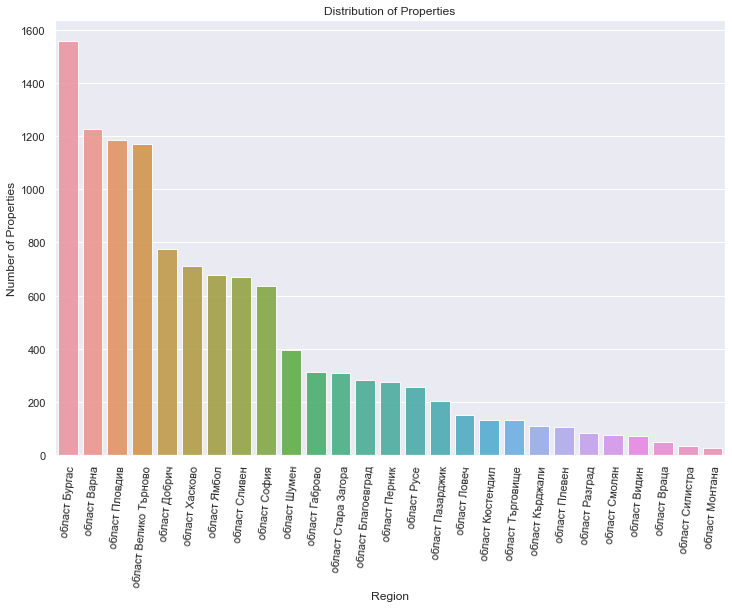

In [64]:
plt.figure(figsize=(12,8))
region_properties = all_houses['region'].value_counts()
sns.set(style="darkgrid")
sns.barplot(region_properties.index, region_properties.values, alpha=0.9)
plt.title('Distribution of Properties')
plt.ylabel('Number of Properties', fontsize=12)
plt.xlabel('Region', fontsize=12)
plt.xticks(rotation=85)
plt.show()

We see something interesting: the region with the Bulgarian capital (and the biggest number of people) offers quite a small number of houses in comparison with other regions of the country. This could mean limited offers and higher prices. We will check that assumption.

In [65]:
all_houses = all_houses.apply(lambda x: x.replace('?', 'no'))

We don`t need columns "url" and "text".

In [66]:
all_houses_columns = all_houses.drop(columns=['url', 'text'])

### Extra column 'income'

We are going to use data from Bulgarian National Statistical Institute for the gross pay by region in September 2022 (the latest available data) [[2]](#Cell2) in order to help algorithms find some patterns (if they exist). There must be some correlation between the income of people, their buying power, and the price of real estate.

In [67]:
income = pd.read_excel('data/Labour_1.1.2.2.xls', skiprows= 5, sheet_name='2022')

In [68]:
income.head(15)

,Unnamed: 0,I,II,III,IV,V,VI,VII,VIII,IX
0,Северозападен район,1224.0,1210.0,1279.0,1368.0,1368.0,1336.0,1360.0,1351.0,1438.0
1,-Видин,1088.0,1066.0,1099.0,1196.0,1178.0,1167.0,1215.0,1164.0,1245.0
2,-Враца,1377.0,1363.0,1468.0,1562.0,1652.0,1496.0,1549.0,1596.0,1698.0
3,-Ловеч,1172.0,1163.0,1246.0,1355.0,1282.0,1275.0,1301.0,1261.0,1364.0
4,-Монтана,1149.0,1144.0,1210.0,1306.0,1262.0,1247.0,1268.0,1263.0,1340.0
5,-Плевен,1225.0,1209.0,1259.0,1327.0,1336.0,1355.0,1357.0,1339.0,1414.0
6,Северен централен район,1239.0,1227.0,1293.0,1367.0,1350.0,1355.0,1398.0,1354.0,1433.0
7,-Велико Търново,1167.0,1135.0,1207.0,1299.0,1293.0,1289.0,1308.0,1307.0,1374.0
8,-Габрово,1324.0,1337.0,1448.0,1501.0,1466.0,1539.0,1501.0,1418.0,1495.0
9,-Разград,1234.0,1286.0,1304.0,1370.0,1333.0,1317.0,1481.0,1365.0,1554.0


In [69]:
s = pd.Series([num for num in range(0, 35)])
income = income.set_index([s])

There is no need to rename columns, they show the average gross pay for 2022. We will use the latest data - from September (the last column).

In [70]:
income = income.drop(columns=['I', 'II', 'III', 'IV', 'V', 'VI', 'VII', 'VIII'])

In [71]:
income['Unnamed: 0'].unique()

array(['Северозападен район', ' -Видин ', ' -Враца', ' -Ловеч',
       ' -Монтана', ' -Плевен', 'Северен централен район',
       ' -Велико Търново', ' -Габрово', ' -Разград', ' -Русе',
       ' -Силистра', 'Североизточен район', ' -Варна', ' -Добрич',
       ' -Търговище', ' -Шумен', 'Югоизточен район', ' -Бургас',
       ' -Сливен', ' -Стара Загора', ' -Ямбол', 'Югозападен район',
       ' -Благоевград', ' -Кюстендил', ' -Перник', ' -София',
       ' -София(столица)', 'Южен централен район', ' -Кърджали',
       ' -Пазарджик', ' -Пловдив', ' -Смолян', ' -Хасково',
       '*предварителни данни'], dtype=object)

We see that the data is inconsistent - we have regional centers, Sofia as the regional center once, Sofia as a city a second time. So we are going to save city's income separately and drop the inconsistent city row. After merging, in the cases when we have in the column "kind_of_settlement": 'capital', we will replace the regional salary with that of the city. It should be good for the work of algorithms since the income in the capital is a lot higher than that in the region of Sofia.

In [72]:
income_capital = income.loc[27, 'IX']

income = income.drop(index = 27)

In [73]:
income['Unnamed: 0'] = income['Unnamed: 0'].apply(lambda x: x.replace(' -', 'област ')).apply(lambda x: x.replace('област София(столица)', 'област София'))
income['Unnamed: 0'] = income['Unnamed: 0'].apply(lambda x: x.replace('област Видин ', 'област Видин'))

In [74]:
income = income.replace([np.inf, -np.inf], np.nan).dropna()

In [75]:
income

,Unnamed: 0,IX
0,Северозападен район,1438.0
1,област Видин,1245.0
2,област Враца,1698.0
3,област Ловеч,1364.0
4,област Монтана,1340.0
5,област Плевен,1414.0
6,Северен централен район,1433.0
7,област Велико Търново,1374.0
8,област Габрово,1495.0
9,област Разград,1554.0


In [76]:
income['Unnamed: 0'] = income['Unnamed: 0'].astype(str) 

In [77]:
income['Unnamed: 0'].dtype

dtype('O')

In [78]:

income['IX'] = income['IX'].astype(int) 

In [79]:
all_houses_columns = all_houses_columns.reset_index(drop=True)

In [80]:
income['Unnamed: 0'].unique()

array(['Северозападен район', 'област Видин', 'област Враца',
       'област Ловеч', 'област Монтана', 'област Плевен',
       'Северен централен район', 'област Велико Търново',
       'област Габрово', 'област Разград', 'област Русе',
       'област Силистра', 'Североизточен район', 'област Варна',
       'област Добрич', 'област Търговище', 'област Шумен',
       'Югоизточен район', 'област Бургас', 'област Сливен',
       'област Стара Загора', 'област Ямбол', 'Югозападен район',
       'област Благоевград', 'област Кюстендил', 'област Перник',
       'област София', 'Южен централен район', 'област Кърджали',
       'област Пазарджик', 'област Пловдив', 'област Смолян',
       'област Хасково'], dtype=object)

In [81]:
all_houses_columns = all_houses_columns.merge(income, how="left", left_on="region", right_on="Unnamed: 0")

In [82]:
all_houses_columns.columns

Index(['price', 'floors', 'size', 'yard', 'sewerage', 'power', 'water_supply',
       'garage', 'view', 'detached_house', 'bbq_gazebo', 'heating_system',
       'pool', 'gated_community', 'water_well', 'solar_panels', 'fireplace',
       'residential_area', 'settlement', 'region', 'kind_of_residential_area',
       'kind_of_settlement', 'Unnamed: 0', 'IX'],
      dtype='object')

In [83]:
all_houses_columns = all_houses_columns.drop(columns = ['Unnamed: 0'])
all_houses_columns = all_houses_columns.rename(columns={"IX": "income"})

In [84]:
all_houses_columns["kind_of_settlement"].unique()

array(['other', 'village', 'city', 'town', 'resort', 'capital'],
      dtype=object)

In [85]:
all_houses_columns.columns

Index(['price', 'floors', 'size', 'yard', 'sewerage', 'power', 'water_supply',
       'garage', 'view', 'detached_house', 'bbq_gazebo', 'heating_system',
       'pool', 'gated_community', 'water_well', 'solar_panels', 'fireplace',
       'residential_area', 'settlement', 'region', 'kind_of_residential_area',
       'kind_of_settlement', 'income'],
      dtype='object')

In [86]:
all_houses_columns['income'] = all_houses_columns.apply(lambda x: int(income_capital) if x["kind_of_settlement"] == 'capital' else x["income"], axis=1)

Let's put it first, in order to be in the group with the other numeric columns. 

In [87]:
cols = all_houses_columns.columns.tolist()
cols = cols[-1:] + cols[:-1]
all_houses_columns = all_houses_columns[cols]

In [88]:
all_houses_columns.columns

Index(['income', 'price', 'floors', 'size', 'yard', 'sewerage', 'power',
       'water_supply', 'garage', 'view', 'detached_house', 'bbq_gazebo',
       'heating_system', 'pool', 'gated_community', 'water_well',
       'solar_panels', 'fireplace', 'residential_area', 'settlement', 'region',
       'kind_of_residential_area', 'kind_of_settlement'],
      dtype='object')

## Data Exploration

Now, we have clean data. Let's see what it is like.

In [89]:
all_houses_columns.shape

(11619, 23)

23 columns and almost 12 thousand observations.

In [90]:
all_houses_columns.describe()

,income,price,floors,size,yard
count,11619.000000,11619.000000,11619.000000,11619.000000,11619.000000
mean,1454.833721,116147.967102,1.846458,176.217931,907.109261
std,180.752237,137062.797879,0.727333,137.232518,1321.505782
min,1195.000000,1785.000000,1.000000,20.000000,0.000000
25%,1374.000000,25500.000000,1.000000,90.000000,287.500000
50%,1412.000000,62000.000000,2.000000,136.000000,650.000000
75%,1538.000000,160000.000000,2.000000,212.000000,1150.000000
max,2423.000000,1000000.000000,4.000000,1000.000000,65000.000000


The mean price is about 116K. We have big and expensive houses, we already mentioned, but small village houses as well. 

Let's see if there is some obvious linearity between the independent variables and the dependent one - our tagret (house price).

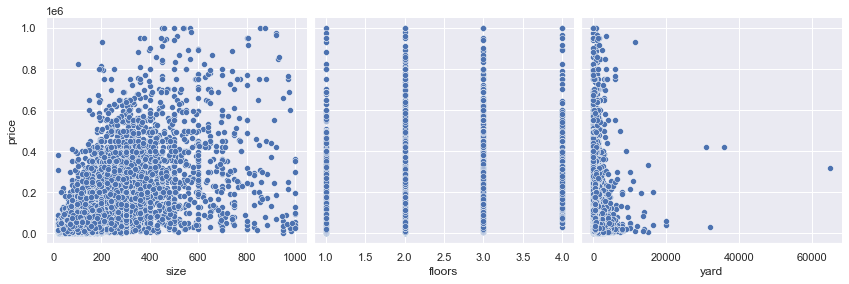

In [91]:
sns.pairplot(all_houses_columns, x_vars=['size', 'floors', 'yard'], y_vars='price', height = 4)
plt.show()

There is an obvious linearity between the price and the size of the houses. This is not true though for the case of the yards' size. it seems that its influence is not proportional to the price. Even when we leave in only the houses in the capital and big cities.

In [92]:
flt_yard = all_houses_columns[(all_houses_columns['kind_of_settlement'] == 'capital') | (all_houses_columns['kind_of_settlement'] == 'city') ]

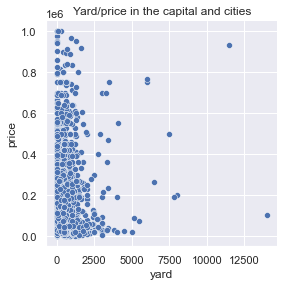

In [93]:
sns.pairplot(flt_yard, x_vars=['yard'], y_vars='price', height = 4)
plt.title("Yard/price in the capital and cities")
plt.show()

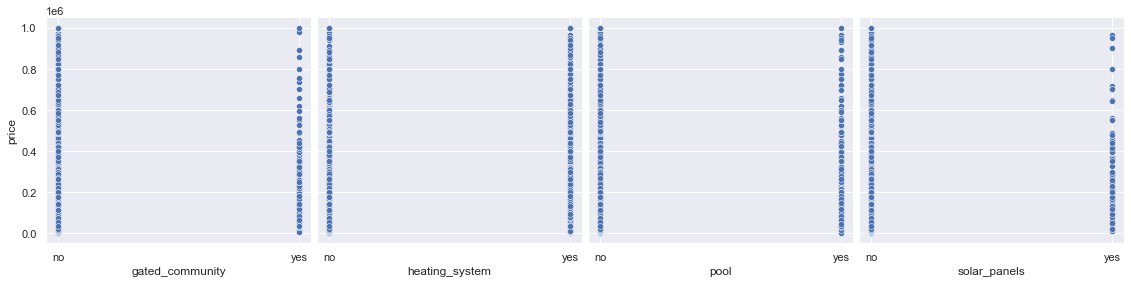

In [94]:
sns.pairplot(all_houses_columns, x_vars=['gated_community', 'heating_system', 'pool', 'solar_panels'], y_vars='price', height = 4)
plt.show()

It seems that pool and solar panels are not so promising. Probably there is some effect of the gated community(in a negative way). 

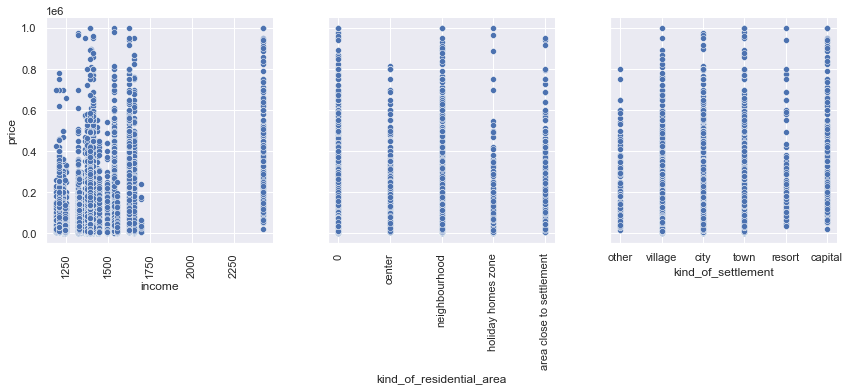

In [95]:
grid = sns.pairplot(all_houses_columns, x_vars=['income', 'kind_of_residential_area', 'kind_of_settlement'], y_vars='price', height = 4)
for ax in grid.axes.flat[:2]:
    ax.tick_params(axis='x', labelrotation=90)
plt.show()

The connection between income and prices is visible, especially in the case of the capital. But it is not so visible, if we talk about the prices and the central parts, where one would expect expensive houses ... the expactations are not met. We already saw earlier, that there are quite a lot of other attractive residential areas.

In [96]:
all_houses_columns[(all_houses_columns['kind_of_residential_area'] == 'center') & (all_houses_columns['kind_of_settlement'] == 'village')].shape

(84, 23)

In [97]:
all_houses_columns[(all_houses_columns['kind_of_residential_area'] == 'center') & (all_houses_columns['kind_of_settlement'] == 'town')].shape

(59, 23)

In [98]:
all_houses_columns[(all_houses_columns['kind_of_residential_area'] == 'center') & (all_houses_columns['kind_of_settlement'] == 'city')].shape

(397, 23)

We see that in every kind of settlement there is a wide spectrum of prices. It would be interesting to see whether the properties in villages closer to the cities have higher prices. It will be difficult for this idea to be put in practice in the time frame of this project though.

We have a lot of zeros in the column "residential area". That means that the column with the kind of residential areas probably will be more efficient.

Let's separate the data into features and a target.

In [99]:
#We will save the data before reseting in order to have access to the older indices whenever needed
all_houses_columns_non_reset = all_houses_columns.copy()

In [100]:
all_houses_columns = all_houses_columns.reset_index(drop=True)

In [101]:
all_houses_columns.columns

Index(['income', 'price', 'floors', 'size', 'yard', 'sewerage', 'power',
       'water_supply', 'garage', 'view', 'detached_house', 'bbq_gazebo',
       'heating_system', 'pool', 'gated_community', 'water_well',
       'solar_panels', 'fireplace', 'residential_area', 'settlement', 'region',
       'kind_of_residential_area', 'kind_of_settlement'],
      dtype='object')

In [102]:
all_house_features = all_houses_columns.drop(columns="price")
all_house_target = all_houses_columns["price"]

We should change some columns so that models can work with them. We are going to convert categorical variables into dummy/indicator variables.

Because we have a lot of residential areas and settlements` names, this will lead to a lot of new columns.

In [103]:
all_house_features_dummies = pd.get_dummies(all_house_features)

We didn't drop the first categories, because we have columns with more than two values (kind_of_settlement, kind_of_residential_area). Now we should go and delete the first columns of the features that have only 'yes' and 'no' values. Otherwise, we will have very correlated columns.

In [104]:
all_house_features_dummies.columns[(all_house_features_dummies.columns.str.contains("_no")) & (~all_house_features_dummies.columns.str.contains("novi"))]

Index(['sewerage_no', 'power_no', 'water_supply_no', 'garage_no', 'view_no',
       'detached_house_no', 'bbq_gazebo_no', 'heating_system_no', 'pool_no',
       'gated_community_no', 'water_well_no', 'solar_panels_no',
       'fireplace_no'],
      dtype='object')

In [105]:
all_house_features_dummies = all_house_features_dummies.drop(columns = all_house_features_dummies.columns[(all_house_features_dummies.columns.str.contains("_no")) & (~all_house_features_dummies.columns.str.contains("novi"))])

In [106]:
all_house_features_dummies.columns

Index(['income', 'floors', 'size', 'yard', 'sewerage_yes', 'power_yes',
       'water_supply_yes', 'garage_yes', 'detached_house_yes',
       'heating_system_yes',
       ...
       'kind_of_residential_area_area close to settlement',
       'kind_of_residential_area_center',
       'kind_of_residential_area_holiday homes zone',
       'kind_of_residential_area_neighbourhood', 'kind_of_settlement_capital',
       'kind_of_settlement_city', 'kind_of_settlement_other',
       'kind_of_settlement_resort', 'kind_of_settlement_town',
       'kind_of_settlement_village'],
      dtype='object', length=2833)

In [107]:
all_house_features_dummies.columns[1000]

'settlement_град Перущица'

### Multicollinearity

We made two columns earlier in order to interpret the meaning of kind of settlement and kind of residenatial area. This, of course, leaded to some multicollinearity. Let's see how much it is.

In the case with the cities, for example, we have some correlation between its kind and the city itself. But because there are many cities, the correlation is not high.

In [108]:
all_house_features_dummies['kind_of_settlement_city'].corr(all_house_features_dummies['settlement_град Пловдив'])

0.2495237059518219

The situation is different with the capital, which alway corresponds to the city of Sofia. We have perfect correlation here. 

In [109]:
all_house_features_dummies['kind_of_settlement_capital'].corr(all_house_features_dummies['settlement_град София'])

1.0

In [110]:
all_house_features_dummies['kind_of_settlement_city'].corr(all_house_features_dummies['settlement_град Пловдив'])

0.2495237059518219

## Linear Regression

We will test the first choice for projects like ours - Linear Regression.

In [111]:
all_house_features_dummies.shape

(11619, 2833)

In [112]:
x_train, x_test, y_train, y_test = train_test_split(all_house_features_dummies, all_house_target, train_size = 0.7, test_size = 0.3, random_state=42)

##### MinMax

We will normalize the numerical columns with MinMaxScaler.

In [113]:
x_train.iloc[:, 0:4]

,income,floors,size,yard
211,1538,1,86.0,921.0
9720,1374,2,80.0,2000.0
5337,1401,2,65.0,1000.0
9330,1374,1,80.0,2000.0
3232,2423,2,152.0,750.0
...,...,...,...,...
11284,1393,1,83.0,1518.0
5191,1448,1,125.0,1153.0
5390,1401,1,60.0,900.0
860,1538,1,85.0,600.0


In [114]:
x_train_minmax = x_train.copy(deep=True)
scaler_minmax = MinMaxScaler()
x_train_minmax.iloc[:, 0:4] = scaler_minmax.fit_transform(x_train.iloc[:, 0:4])

Let's fit the data.

In [115]:
linear_regression = LinearRegression()
linear_regression.fit(x_train_minmax, y_train)

LinearRegression()

In [116]:
x_test_minmax = x_test.copy(deep=True)
x_test_minmax.iloc[:, 0:4] = scaler_minmax.transform(x_test.iloc[:, 0:4])

In [117]:
pred_y = linear_regression.predict(x_test_minmax)
mse = mean_squared_error(y_test, pred_y) 

In [118]:
print(f"R-square score test MinMaxScaler: {linear_regression.score(x_test_minmax, y_test)}, MSE: {mse}")

R-square score test MinMaxScaler: -1.2680344086921444e+22, MSE: 2.1803612081427442e+32


In [119]:
print(f"R-square score train: {linear_regression.score(x_train_minmax, y_train)}")
print(f"R-square score test: {linear_regression.score(x_test_minmax, y_test)}")

R-square score train: 0.7498655605261677
R-square score test: -1.2680344086921444e+22


The score is not very impressive.

##### StandardScaler

Sometimes the kind of scaling can lead to different result. We are going to check it.

In [120]:
x_train_ss = x_train.copy(deep=True)
scaler_ss = StandardScaler()
x_train_ss.iloc[:, 0:4] = scaler_ss.fit_transform(x_train.iloc[:, 0:4])

In [121]:
linear_regression = LinearRegression()
linear_regression.fit(x_train_ss, y_train)

LinearRegression()

In [122]:
x_test_ss = x_test.copy(deep=True)
x_test_ss.iloc[:, 0:4] = scaler_ss.transform(x_test.iloc[:, 0:4])

In [123]:
pred_y = linear_regression.predict(x_test_ss)
mse = mean_squared_error(y_test, pred_y) 

In [124]:
print(f"R-square score test StandardScaler: {linear_regression.score(x_test_ss, y_test)}, MSE: {mse}")

R-square score test StandardScaler: -2.925311633288783e+21, MSE: 5.030018084075568e+31


In [125]:
print(f"R-square score train: {linear_regression.score(x_train_ss, y_train)}")
print(f"R-square score test: {linear_regression.score(x_test_ss, y_test)}")

R-square score train: 0.7510332261952488
R-square score test: -2.925311633288783e+21


We get bad results, no matther what kind of normalization we use. The worst with MinMaxScaler, though.

##### Feature elimination and LinearRegression

Let's see if we will get betters results by removing some variables.

In [126]:
all_house_features.columns

Index(['income', 'floors', 'size', 'yard', 'sewerage', 'power', 'water_supply',
       'garage', 'view', 'detached_house', 'bbq_gazebo', 'heating_system',
       'pool', 'gated_community', 'water_well', 'solar_panels', 'fireplace',
       'residential_area', 'settlement', 'region', 'kind_of_residential_area',
       'kind_of_settlement'],
      dtype='object')

In [127]:
all_house_features_without = all_house_features.drop(columns=['sewerage',
       'view', 'bbq_gazebo', 'gated_community', 'residential_area', 'settlement'])

In [128]:
all_house_features_without.columns

Index(['income', 'floors', 'size', 'yard', 'power', 'water_supply', 'garage',
       'detached_house', 'heating_system', 'pool', 'water_well',
       'solar_panels', 'fireplace', 'region', 'kind_of_residential_area',
       'kind_of_settlement'],
      dtype='object')

In [129]:
all_house_features_without_some_dummies = pd.get_dummies(all_house_features_without)

In [130]:
all_house_features_without_some_dummies = all_house_features_without_some_dummies.drop(columns = all_house_features_without_some_dummies.columns[(all_house_features_without_some_dummies.columns.str.contains("_no")) & (~all_house_features_without_some_dummies.columns.str.contains("novi"))])

In [131]:
all_house_features_without_some_dummies.columns

Index(['income', 'floors', 'size', 'yard', 'power_yes', 'water_supply_yes',
       'garage_yes', 'detached_house_yes', 'heating_system_yes', 'pool_yes',
       'water_well_yes', 'solar_panels_yes', 'fireplace_yes',
       'region_област Благоевград', 'region_област Бургас',
       'region_област Варна', 'region_област Велико Търново',
       'region_област Видин', 'region_област Враца', 'region_област Габрово',
       'region_област Добрич', 'region_област Кърджали',
       'region_област Кюстендил', 'region_област Ловеч',
       'region_област Монтана', 'region_област Пазарджик',
       'region_област Перник', 'region_област Плевен', 'region_област Пловдив',
       'region_област Разград', 'region_област Русе', 'region_област Силистра',
       'region_област Сливен', 'region_област Смолян', 'region_област София',
       'region_област Стара Загора', 'region_област Търговище',
       'region_област Хасково', 'region_област Шумен', 'region_област Ямбол',
       'kind_of_residential_area

In [132]:
x_train_without, x_test_without, y_train, y_test = train_test_split(all_house_features_without_some_dummies, all_house_target, train_size = 0.7, test_size = 0.3, random_state=42)

In [133]:
x_train_without.iloc[:, 0:3]

,income,floors,size
211,1538,1,86.0
9720,1374,2,80.0
5337,1401,2,65.0
9330,1374,1,80.0
3232,2423,2,152.0
...,...,...,...
11284,1393,1,83.0
5191,1448,1,125.0
5390,1401,1,60.0
860,1538,1,85.0


In [134]:
x_train_minmax_without = x_train_without.copy(deep=True)
scaler_minmax = MinMaxScaler()
x_train_minmax_without.iloc[:, 0:4] = scaler_minmax.fit_transform(x_train_without.iloc[:, 0:4])

In [135]:
linear_regression = LinearRegression()
linear_regression.fit(x_train_minmax_without, y_train)

LinearRegression()

In [136]:
x_test_minmax_without = x_test_without.copy(deep=True)
x_test_minmax_without.iloc[:, 0:4] = scaler_minmax.transform(x_test_without.iloc[:, 0:4])

In [137]:
pred_y = linear_regression.predict(x_test_minmax_without)
mse = mean_squared_error(y_test, pred_y) 

In [138]:
print(f"R-square score test MinMaxScaler: {linear_regression.score(x_test_minmax_without, y_test)}, MSE: {mse}")

R-square score test MinMaxScaler: 0.561261699348601, MSE: 7544022186.696242


In [139]:
print(f"R-square score train: {linear_regression.score(x_train_minmax_without, y_train)}")
print(f"R-square score test: {linear_regression.score(x_test_minmax_without, y_test)}")

R-square score train: 0.5632742784915834
R-square score test: 0.561261699348601


We see that after removing a great deal of information about the houses, the score improved dramatically. It was expected earlier because we knew that some of the advantages exist in many houses without being explicitly mentioned. Moreover, we knew that there is multicollinearity in our dataset (in regard to the kinds of areas and settlements).

What makes an impression is that the heating system makes the result better with (about) 0.01, pool: 0.00003, power: 0.004, water-supply: 0.001, garage: 0.005, detached house: 0.005, water-well: 0.001, solar panels: 0.0006, fireplace: 0.001. BBQ-gazebo: no difference. After adding the column with the kinds of settlement (initially it didn't exist), the result increased by 0.03 (therefore there is some relation between kind of settlement and price, but we saw this earlier - on the pairplot the prices of the houses in the cities and in the capital were higher than those in the villages and towns).

It is worth noting that initially houses over 1000 sq.m. were not deleted. This led to the R-squared score of 0.4717. After removing these outliers the score incressed by 0.028. Unfortunately, the model potential for overfitting also increased (it was higher than the test results). 
After that houses with prices over 1 million EUR were removed. Since luxury is not a variable here, we can't measure it. 
But in this group though there were quite a lot of properties in a very central place, usually with big sizes (luxurous and not that much). Central location and size are two variables that are measured here so we expected the result to fall. It seems though that it's not the case. The score rose from 0.4995 to 0.5613. The training and testing results got equal. After careful analize we noticed that these is something special about these buildings - they are symbolyc ones and/or at a special places, mainly in the cities. 

Before removing the two groups as outliers, the variable 'income' was irrelevant to the price. It was initially dropped out becuse it used to decrease the results. No, we see that it already increses the score, albeit with only 0.0001.

The above details are recorded during defferent feature elimination steps. Due to the 
relativity, we've already witnessed in the case of income, it is possible the result from specific variable dropping to lead to different results (in comparison with the outcome of the previous stage of fuature selection).

We managed to increase the results manually. But it will be necessary to decrease the size of the data and to get the best of what is left - in order to be able to test the algorithms. That is the reson to try feature elimination harder. Let's see if we can get better score with SelectKBest.

##### SelectKBest with MinMaxScaler

In [140]:
def select_features(X_train, y_train, X_test, n_k):
    fs = SelectKBest(score_func=f_regression, k=n_k)
    fs.fit(X_train, y_train)
    X_train_fs = fs.transform(X_train)
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs, fs

invalid value encountered in true_divide


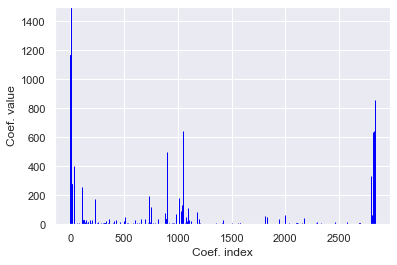

In [141]:
x_train_fs, X_test_fs, fs = select_features(x_train_minmax, y_train, x_test_minmax, 'all')

plt.bar([i for i in range(len(fs.scores_))], fs.scores_, edgecolor='blue')
plt.ylim(0, 1500)
plt.xlabel('Coef. index')
plt.ylabel('Coef. value')
plt.show()

We see that about 17 variables are the most important. Let's apply this selection and see the results. After that with trial and error we can see when we have better results. First, with MinMaxScaler.

MinMax

<b>17 features:</b>

In [142]:
x_train_fs, x_test_fs, fs = select_features(x_train_minmax, y_train, x_test_minmax, 17)

invalid value encountered in true_divide


In [143]:
linear_regression = LinearRegression()
linear_regression.fit(x_train_fs, y_train)

LinearRegression()

In [144]:
pred_y = linear_regression.predict(x_test_fs)
mse = mean_squared_error(y_test, pred_y) 

In [145]:
print(f"R-square score test MinMaxScaler: {linear_regression.score(x_test_fs, y_test)}, MSE: {mse}")

R-square score test MinMaxScaler: 0.5147812155079086, MSE: 8343245324.548459


In [146]:
print(f"R-square score train: {linear_regression.score(x_train_fs, y_train)}")
print(f"R-square score test: {linear_regression.score(x_test_fs, y_test)}")

R-square score train: 0.5247006274853911
R-square score test: 0.5147812155079086


<b>1030 features:</b>

In [147]:
x_train_fs, x_test_fs, fs = select_features(x_train_minmax, y_train, x_test_minmax, 1030)

invalid value encountered in true_divide


In [148]:
linear_regression = LinearRegression()
linear_regression.fit(x_train_fs, y_train)

LinearRegression()

In [149]:
pred_y = linear_regression.predict(x_test_fs)
mse = mean_squared_error(y_test, pred_y) 

In [150]:
print(f"R-square score test MinMaxScaler: {linear_regression.score(x_test_fs, y_test)}, MSE: {mse}")

R-square score test MinMaxScaler: 0.6347163306912915, MSE: 6280983678.90673


In [151]:
print(f"R-square score train: {linear_regression.score(x_train_fs, y_train)}")
print(f"R-square score test: {linear_regression.score(x_test_fs, y_test)}")

R-square score train: 0.7166675913406411
R-square score test: 0.6347163306912915


So, after some number-of-features testing, in the end, we chose 1030 because these features provide best results. It is good these trials to be made with GridSearchCV but we do not possess big computational power and consider algorithms testing more important.

We see that our algorithm starts overfitting a lot.

##### SelectKBest with StandardScale

In [153]:
x_train_fs_ss, x_test_fs_ss, fs_ss = select_features(x_train_ss, y_train, x_test_ss, 1055)

invalid value encountered in true_divide


In [153]:
linear_regression = LinearRegression()
linear_regression.fit(x_train_fs_ss, y_train)

LinearRegression()

In [154]:
pred_y_ss = linear_regression.predict(x_test_fs_ss)
mse = mean_squared_error(y_test, pred_y_ss) 

In [155]:
print(f"R-square score test StandardScaler: {linear_regression.score(x_test_fs_ss, y_test)}, MSE: {mse}")

R-square score test StandardScaler: 0.6353051749064487, MSE: 6270858613.880361


In [156]:
print(f"R-square score train: {linear_regression.score(x_train_fs_ss, y_train)}")
print(f"R-square score test: {linear_regression.score(x_test_fs_ss, y_test)}")

R-square score train: 0.7176094283906728
R-square score test: 0.6353051749064487


There is a very, very slight difference between the two results. With 1055 features, it is in StandardScaler's favor now. (Before reducing the 'no' columns (produced by get_dummies) above, in this section MinMaxScaler's result was a little better. That's why it was used in all the work done below).

...

Good job, SelectKBest! Better results than ours. Algorithms easily can replace the manual labour of humans. But overfitting is still a big issue.

### Polynomial Regression

In order Polynomial regression to catch the weakest signals, we will normalize it later. 
Let's try with the manually selected dataset.

In [510]:
all_house_features_without_some_dummies.shape

(11619, 48)

In [2040]:
poly = PolynomialFeatures(degree=2, include_bias=False)
poly_features = poly.fit_transform(all_house_features_without_some_dummies)
x_train_poly, x_test_poly, y_train, y_test = train_test_split(poly_features, all_house_target, test_size=0.3, random_state=42)

In [2041]:
scaler_minmax = MinMaxScaler()
x_train_poly_minmax= scaler_minmax.fit_transform(x_train_poly)
x_test_poly_minmax = scaler_minmax.transform(x_test_poly)

In [2042]:
poly_reg_model = LinearRegression()
poly_reg_model.fit(x_train_poly_minmax, y_train)

LinearRegression()

In [2043]:
pred_y = poly_reg_model.predict(x_test_poly_minmax)
mse = mean_squared_error(y_test, pred_y) 

In [2044]:
print(f"R-square score test MinMaxScaler: {poly_reg_model.score(x_test_poly_minmax, y_test)}, MSE: {mse}")

R-square score test MinMaxScaler: -4.912123103229605e+20, MSE: 8.446302868823672e+30


In [2045]:
print(f"R-square score train: {poly_reg_model.score(x_train_poly_minmax, y_train)}")
print(f"R-square score test: {poly_reg_model.score(x_test_poly_minmax, y_test)}")

R-square score train: 0.6922311725981712
R-square score test: -4.912123103229605e+20


Polynomial regression cannot find good model to predict results. With degree = 3 the results are even worse. The memory of the device (used for the project) doesn't allow us to test degree=4, neither the data with the variables that were excluded earlier.

### ElasticNet

We saw that we improved dramatically results by removing a great deal of variables and by adding two - "kind_of_residenatial_area" and "kind_of_settlement". SelectKBest made the score even better.

Now let's see what we can achieve by regularization. Because SelectKBest and linear regression found some important coefficients, we can expect ElasticNet to improve the results. We will let this algorithm deside on its own what kind of regilarization to use.

In [233]:
cv = RepeatedKFold(n_splits=3, n_repeats=3, random_state=42)
# define model
ratios = [0, 1, 0.01, 0.3, 0.5, 0.7, 0.9]
alphas = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.0, 1.0, 10.0, 100.0]
model_minmax = ElasticNetCV(l1_ratio=ratios, alphas=alphas, cv=cv, n_jobs=-1)
# fit model
model_minmax.fit(x_train_fs, y_train)
# summarize chosen configuration

Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
Objective did not converge. You might want to increase the number of iterations. Duality gap: 29996659726.878906, tolerance: 10783581941.729126
Objective did not converge. You might want to increase the number of iterations. Duality gap: 53847780991953.83, tolerance: 10783581941.729126
Coordinate descent with alpha=0 may lead to unexp

ElasticNetCV(alphas=[1e-05, 0.0001, 0.001, 0.01, 0.1, 0.0, 1.0, 10.0, 100.0],
             cv=RepeatedKFold(n_repeats=3, n_splits=3, random_state=42),
             l1_ratio=[0, 1, 0.01, 0.3, 0.5, 0.7, 0.9], n_jobs=-1)

#### End of ElasticNet SelectKBest GridSearch

#### Results

In [234]:
print(f'alpha: {model_minmax.alpha_}')
print(f'l1_ratio_: {model_minmax.l1_ratio_}')

alpha: 0.001
l1_ratio_: 0.7


In [235]:
print(f"R-square score train: {model_minmax.score(x_train_fs, y_train)}")
print(f"R-square score test: {model_minmax.score(x_test_fs, y_test)}")

R-square score train: 0.6928875401746749
R-square score test: 0.6532693639090492


In [437]:
np.sqrt(mean_squared_error(y_test, model_minmax.predict(x_test_fs)))

77213.77971608455

In [438]:
np.sqrt(mean_squared_error(y_train, model_minmax.predict(x_train_fs)))

77308.95613795031

The score is quite impressive. 0.65 is the highest result achieved so far. The optimum regularization turned out to be the mixed one, tending to L1: 0.7. The RMSE shows no overfitting. The performance on the testing data is even better.

### ElasticNet with all features

Let's see if ElasticNet will perform so well on the whole dataset. This could be the solution for overfitting.

Before that we will run the x_train_minmax and x_test_minmax again, because they were used in the Polynomial regression.

In [2049]:
x_train_minmax = x_train.copy()
scaler_minmax = MinMaxScaler()
x_train_minmax.iloc[:, 0:4] = scaler_minmax.fit_transform(x_train.iloc[:, 0:4])

In [2050]:
x_test_minmax = x_test.copy(deep=True)
x_test_minmax.iloc[:, 0:4] = scaler_minmax.transform(x_test.iloc[:, 0:4])

In [2051]:
cv = RepeatedKFold(n_splits=3, n_repeats=3, random_state=42)
# define model
ratios = [0, 1, 0.01, 0.3, 0.5, 0.7]
alphas = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.0, 1.0, 10.0, 100.0]
model_minmax = ElasticNetCV(l1_ratio=ratios, alphas=alphas, cv=cv, n_jobs=-1)
# fit model
model_minmax.fit(x_train_minmax, y_train)
# summarize chosen configuration

C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_mod

ElasticNetCV(alphas=[1e-05, 0.0001, 0.001, 0.01, 0.1, 0.0, 1.0, 10.0, 100.0],
             cv=RepeatedKFold(n_repeats=3, n_splits=3, random_state=42),
             l1_ratio=[0, 1, 0.01, 0.3, 0.5, 0.7], n_jobs=-1)

##### End of ElasticNet with all features

In [2052]:
print(f'alpha: {model_minmax.alpha_}')
print(f'l1_ratio_: {model_minmax.l1_ratio_}')

alpha: 0.001
l1_ratio_: 0.5


##### Results

In [2057]:
x_test_minmax = x_test.copy(deep=True)
x_test_minmax.iloc[:, 0:4] = scaler_minmax.transform(x_test.iloc[:, 0:4])

In [2058]:
pred_y = model_minmax.predict(x_test_minmax)
mse = mean_squared_error(y_test, pred_y) 

In [2059]:
print(f"R-square score test ElasticNet with MinMaxScaler: {model_minmax.score(x_test_minmax, y_test)}, MSE: {mse}")

R-square score test ElasticNet with MinMaxScaler: 0.6578564481795018, MSE: 5883093730.674191


In [2060]:
print(f"R-square score train: {model_minmax.score(x_train_minmax, y_train)}")
print(f"R-square score test: {model_minmax.score(x_test_minmax, y_test)}")

R-square score train: 0.703265005564564
R-square score test: 0.6578564481795018


It turned out that the best model here includes the combination of L1 and l2. The score is almost the same as the one we got with the selected features by SelectKBest (0.6511 vs 0.6578 here). Its overfitting potential though is higher (0.6824 vs 0.7032). 

### PCA

Let's try an algorithm good in reducing the dimension of the feature space - Principal Component Analysis. Like ELasticNet, PCA also can help us solve the problem with multicolinearity and even provide better results.
First, we will test with the groups with selected features by SelectKBest, after that with all features.

In [2061]:
pipe = Pipeline([('pca', PCA(n_components = 588)),('estimator', LinearRegression())])
pipe.fit(x_train_fs, y_train)

Pipeline(steps=[('pca', PCA(n_components=588)),
                ('estimator', LinearRegression())])

In [2062]:
pipe.score(x_test_fs, y_test)

0.645589859380357

In [2063]:
print(f"R-square score train: {pipe.score(x_train_fs, y_train)}")
print(f"R-square score test: {pipe.score(x_test_fs, y_test)}")

R-square score train: 0.6705907803946827
R-square score test: 0.645589859380357


After testing different number of components, those around 588 turned out to be the best choice. PCA, though, didn't manage to overtake the ElasticNet results.

In [2064]:
x_train, x_test, y_train, y_test = train_test_split(all_house_features_dummies, all_house_target, train_size = 0.7, test_size = 0.3, random_state=42)

In [2065]:
pipe = Pipeline([('scaler', MinMaxScaler()), ('pca', PCA(n_components = 1223)),('estimator', LinearRegression())])
pipe.fit(x_train, y_train)

Pipeline(steps=[('scaler', MinMaxScaler()), ('pca', PCA(n_components=1223)),
                ('estimator', LinearRegression())])

In [2066]:
pipe.score(x_test, y_test)

0.642964774931337

In [2067]:
pred_y = pipe.predict(x_test)
mse = mean_squared_error(y_test, pred_y) 

In [2068]:
print(f"R-square score test Pipeline: {pipe.score(x_test, y_test)}, MSE: {mse}")

R-square score test Pipeline: 0.642964774931337, MSE: 6139153238.618653


In [2069]:
print(f"R-square score train: {pipe.score(x_train, y_train)}")
print(f"R-square score test: {pipe.score(x_test, y_test)}")

R-square score train: 0.7090394133099487
R-square score test: 0.642964774931337


After tests with the hyperparameter n_components the maximum result is achieved with about 1223 components.

In [2070]:
pipe['pca'].explained_variance_ratio_

array([2.08630260e-01, 1.17643505e-01, 5.82620470e-02, ...,
       2.55770809e-05, 2.54658449e-05, 2.53309277e-05])

The components here play important role. If pca is allowed to use the same number of columns, then the score is very bad. If we use small number, the results are also bad. We can see why - explained_variance_ratio shows that even the most important columns barely cover 0.14% and 0.12% of the variance. And the columns further - even far less (see the graph below).

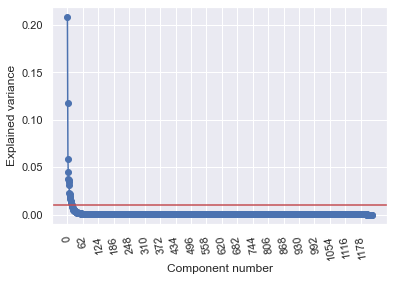

In [2071]:
num_pcs = len(pipe['pca'].explained_variance_ratio_)
plt.plot(pipe['pca'].explained_variance_ratio_)
plt.scatter(range(num_pcs), pipe['pca'].explained_variance_ratio_)

plt.axhline(0.01, c="r") 

plt.xticks(range(num_pcs))
plt.xlabel("Component number")
plt.xticks(rotation=100)
plt.ylabel("Explained variance")
plt.locator_params(axis='x', nbins=20)
plt.show()

This small contribution to the overall result make us doubt  that some non-linear patterns exist. Since we are here, probably it will be a good idea to test kernelPCA.

In [2072]:
pipe = Pipeline([('pca', KernelPCA(n_components = 588)),('estimator', LinearRegression())])
pipe.fit(x_train_fs, y_train)

Pipeline(steps=[('pca', KernelPCA(n_components=588)),
                ('estimator', LinearRegression())])

In [2073]:
pipe.score(x_test_fs, y_test)

0.643400574671243

In [2074]:
print(f"R-square score train: {pipe.score(x_train_fs, y_train)}")
print(f"R-square score test: {pipe.score(x_test_fs, y_test)}")

R-square score train: 0.6686190333856439
R-square score test: 0.643400574671243


In [2075]:
pipe = Pipeline([('scaler', MinMaxScaler()), ('pca', KernelPCA(n_components = 1223)),('estimator', LinearRegression())])
pipe.fit(x_train, y_train)

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('pca', KernelPCA(n_components=1223)),
                ('estimator', LinearRegression())])

In [2076]:
pipe.score(x_test, y_test)

0.6418384018527261

In [2077]:
pred_y = pipe.predict(x_test)
mse = mean_squared_error(y_test, pred_y) 

In [2078]:
print(f"R-square score test Pipeline: {pipe.score(x_test, y_test)}, MSE: {mse}")

R-square score test Pipeline: 0.6418384018527261, MSE: 6158521010.894111


In [2079]:
print(f"R-square score train: {pipe.score(x_train, y_train)}")
print(f"R-square score test: {pipe.score(x_test, y_test)}")

R-square score train: 0.7107231757364858
R-square score test: 0.6418384018527261


Kernel PCA didn't achieve better results (in comparison with eartlier tests - without feature selection its performance was better than that of the standard PCA). 
It is intresting to see whether if we reduce some more outliers with RANSAC, LinearRegression would achive better results

### RANSAC and LinearRegression

In [157]:
ransac = RANSACRegressor(
    base_estimator=LinearRegression(),
    min_samples=0.25, 
)

In [158]:
ransac.fit(x_train_fs, y_train)

RANSACRegressor(base_estimator=LinearRegression(), min_samples=0.25)

In [160]:
print(f"R-square score train: {ransac.score(x_train_fs[ransac.inlier_mask_], y_train[ransac.inlier_mask_])}")

R-square score train: 0.9467715201767646


<b> With Test Dataset </b>

In [162]:
ransac.fit(x_test_fs, y_test)

RANSACRegressor(base_estimator=LinearRegression(), min_samples=0.25)

In [163]:
print(f"R-square score test: {ransac.score(x_test_fs[ransac.inlier_mask_], y_test[ransac.inlier_mask_])}")

R-square score test: 0.9514847328150078


The results are quite impressive. But we should keep in mind that they include only the inliers. Let's do some more tests.

<b> With smaller min_sample </b>

In [167]:
ransac = RANSACRegressor(
    base_estimator=LinearRegression(),
    min_samples=0.05, 
)
ransac.fit(x_train_fs, y_train)

RANSACRegressor(base_estimator=LinearRegression(), min_samples=0.05)

In [168]:
print(f"R-square score train: {ransac.score(x_train_fs[ransac.inlier_mask_], y_train[ransac.inlier_mask_])}")

R-square score train: 0.9390656102580514


<b> With Test Dataset </b>

In [171]:
ransac.fit(x_test_fs, y_test)

RANSACRegressor(base_estimator=LinearRegression(), min_samples=0.05)

In [172]:
print(f"R-square score test: {ransac.score(x_test_fs[ransac.inlier_mask_], y_test[ransac.inlier_mask_])}")

R-square score test: 0.9534464022836602


<b> With bigger min_sample </b>

In [154]:
ransac = RANSACRegressor(
    base_estimator=LinearRegression(),
    min_samples=0.55, 
)
ransac.fit(x_train_fs, y_train)

RANSACRegressor(base_estimator=LinearRegression(), min_samples=0.55)

In [155]:
print(f"R-square score train: {ransac.score(x_train_fs[ransac.inlier_mask_], y_train[ransac.inlier_mask_])}")

R-square score train: 0.9502360990450147


<b> With Test Dataset </b>

In [156]:
ransac.fit(x_test_fs, y_test)

RANSACRegressor(base_estimator=LinearRegression(), min_samples=0.55)

In [157]:
print(f"R-square score test: {ransac.score(x_test_fs[ransac.inlier_mask_], y_test[ransac.inlier_mask_])}")

R-square score test: 0.9587396791768015


RANSAC's performance with inliers is outstanding. The last instance reached highest scores on the testing dataset. Let's see what the results are with the whole test data. 

In [158]:
print(f"R-square score test: {ransac.score(x_test_fs, y_test)}")

R-square score test: -1.3294414079921362e+22


Not very good. But it could be helpful to use it in the final results.

## Algorithms testing

From what we have learnt so far we have many columns with small influence on the price. The algorithms that can regulate their number and importance managed to achieve better results. We got R-Squared 0.56 when performed LinearRegression after manual feature elimination. SelectKBest helped us find the best combination, which led to the score of about 0.64, but also to overfitting. ElasticNet overtook it with 0.65 (mitigating a little the overfitting). RANSAC outperformed them with 0.957, but only with the inliers. Now let's see what results other algorithms could provide. 

In [189]:
sys.getsizeof(x_test_minmax)

10265256

In [207]:
sys.getsizeof(x_train_minmax)

691672

The biggest challange that we faced with this project was to find a way to test the potential algorithms with larger dataset, limited computational power, and limited time. That's why we tested different ways of feature selection, extraction and engineering. Now, we can continue with other algorithms by using the optimal data - the result from SelectKBest.

### RandomSearch 1

In this case we will use RandomizedSerachCV due to the limitations we've already mentioned. It will be used twice with different algorithms.

In [1378]:
cl0 = DecisionTreeRegressor(min_samples_leaf=2, random_state=42)
cl1 = DecisionTreeRegressor(min_samples_leaf=7, random_state=42)
cl2 = RandomForestRegressor(n_estimators = 2000, min_samples_leaf=5, random_state=42)
cl3 = RandomForestRegressor(n_estimators = 5000, min_samples_leaf=15, random_state=42)


#Ada
pipe_ada_regr_tree = Pipeline([('clf', AdaBoostRegressor(base_estimator=DecisionTreeRegressor()))])
pipe_ada_regr_forest = Pipeline([('clf', AdaBoostRegressor(base_estimator=RandomForestRegressor()))])

#DecisionTree
pipe_decision_tree = Pipeline([('clf', DecisionTreeRegressor())])

#RandomForest
pipe_random_forest_regr = Pipeline([('clf', RandomForestRegressor())])


#Stacking
pipe_sc1 = Pipeline([('clf', StackingRegressor(estimators=[('dtr_1', cl0), ('dtr_2', cl1)]))])
pipe_sc2 = Pipeline([('clf', StackingRegressor(estimators=[('dtr_3', cl2), ('dtr_4', cl3)]))])
                      
#XGBoost
pipe_xgb = Pipeline([('clf', XGBRegressor())])

In [1379]:
#Setting grid search params

#AdaTree
grid_params_ada_regr_tree = [{
    'clf__n_estimators' : [500, 1000, 2000],
    'clf__random_state' : [42]
}]

#AdaForest
grid_params_ada_regr_forest = [{
    'clf__n_estimators' : [2, 5],
    'clf__random_state' : [42]
}]

#DecisionTree
grid_params_decision_tree = [{
    'clf__min_samples_leaf': [1, 2, 5],
    'clf__random_state' : [42]
}]

#RandomForests
grid_params_random_forest_regr = [{
    'clf__n_estimators' : [500, 1000, 2000],
    'clf__min_samples_leaf': [2, 5],
    'clf__random_state' : [42]
}]


#Stacking
grid_params_sreg = [{
    'clf__passthrough': [True, False]
}]

#XGBoost
grid_params_xgb = [{
    'clf__n_estimators' : [500, 1000, 2000],
    'clf__learning_rate': [0.001, 0.01, 0.1],
    'clf__random_state' : [42]
}]

In [1380]:
#Create grid search

#Ada
gs_ada_regr_tree = RandomizedSearchCV(estimator=pipe_ada_regr_tree,
param_distributions=grid_params_ada_regr_tree,
scoring='r2',
cv = 3,
n_jobs=-1)

#Ada
gs_ada_regr_forest = RandomizedSearchCV(estimator=pipe_ada_regr_forest,
param_distributions=grid_params_ada_regr_forest,
scoring='r2',
cv = 3,
n_jobs=-1)

#DecisionTree
gs_decision_tree = RandomizedSearchCV(estimator=pipe_decision_tree,
param_distributions=grid_params_decision_tree,
scoring='r2',
cv = 3,
n_jobs=-1)

#RandomForest
gs_random_forest = RandomizedSearchCV(estimator=pipe_random_forest_regr,
param_distributions=grid_params_random_forest_regr,
scoring='r2',
cv = 3,
n_jobs=-1)

#Stacking
gs_sc1 = RandomizedSearchCV(estimator=pipe_sc1,
param_distributions=grid_params_sreg,
scoring='r2',
cv = 3,
n_jobs=-1)

gs_sc2 = RandomizedSearchCV(estimator=pipe_sc2,
param_distributions=grid_params_sreg,
scoring='r2',
cv = 3,
n_jobs=-1)


#XGBoost
gs_xgb = RandomizedSearchCV(estimator=pipe_xgb,
param_distributions=grid_params_xgb,
scoring='r2',
cv = 3,
n_jobs=-1)

In [1381]:
#List of grid pipelines
grids = [gs_ada_regr_tree, gs_ada_regr_forest, gs_decision_tree, gs_random_forest, gs_sc1, gs_sc2, gs_xgb]

In [1383]:
#Grid dictionary for pipeline/estimator

grid_dict = {0:'AdaBoostRegressor(DecisionTree)', 1:'AdaBoostRegressor(RandomForest)', 2:'DecisionTree', 3:'RandomForestRegressor',  4: 'StackingRegressor 1', 5: 'StackingRegressor 2', 6:'XGBoostRegressor'}

In [1384]:
#Fit the pipeline of estimators using gridsearchcv


print('Fitting the randomsearchcv to pipeline of estimators…')
total_scores = []
for gsid, gs in enumerate(grids):
    print(f'Estimator: {grid_dict[gsid]}')
    gs.fit(x_train_fs, y_train)
    print(f'Best score : {gs.best_score_:.5f}')
    print(f'Best grid params: {gs.best_params_}')
    y_pred = gs.predict(x_test_fs)
    
    # R2 score
    score_train = r2_score(y_train, gs.predict(x_train_fs))
    score_test = r2_score(y_test, y_pred)
    diff = score_train - score_test
    print(f'R2_score: {score_test}')
    print(f'Difference between R2 score of training and testing datasets: {diff}')
    total_scores.append([grid_dict[gsid], gs.best_score_, gs.best_params_, diff, gs.best_estimator_])

Fitting the randomsearchcv to pipeline of estimators…
Estimator: AdaBoostRegressor(DecisionTree)


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:292: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best score : 0.64233
Best grid params: {'clf__random_state': 42, 'clf__n_estimators': 2000}
R2_score: 0.6045532298756793
Difference between R2 score of training and testing datasets: 0.3893850821069528
Estimator: AdaBoostRegressor(RandomForest)


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:292: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best score : 0.66065
Best grid params: {'clf__random_state': 42, 'clf__n_estimators': 5}
R2_score: 0.6349665923386443
Difference between R2 score of training and testing datasets: 0.33622821838928973
Estimator: DecisionTree


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:292: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best score : 0.51189
Best grid params: {'clf__random_state': 42, 'clf__min_samples_leaf': 5}
R2_score: 0.4550404915925208
Difference between R2 score of training and testing datasets: 0.3402450531654031
Estimator: RandomForestRegressor


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:292: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best score : 0.64851
Best grid params: {'clf__random_state': 42, 'clf__n_estimators': 1000, 'clf__min_samples_leaf': 2}
R2_score: 0.6323371478899315
Difference between R2 score of training and testing datasets: 0.2760660486968046
Estimator: StackingRegressor 1


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:292: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
1 fits failed out of a total of 6.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\pipeline.py", line 39

Best score : 0.56981
Best grid params: {'clf__passthrough': False}
R2_score: 0.5560409926943521
Difference between R2 score of training and testing datasets: 0.2693865543290177
Estimator: StackingRegressor 2


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:292: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best score : 0.66844
Best grid params: {'clf__passthrough': True}
R2_score: 0.5120351244685069
Difference between R2 score of training and testing datasets: 0.09577364493257712
Estimator: XGBoostRegressor


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:292: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best score : 0.67259
Best grid params: {'clf__random_state': 42, 'clf__n_estimators': 1000, 'clf__learning_rate': 0.1}
R2_score: 0.6622419183149806
Difference between R2 score of training and testing datasets: 0.24409319574328892


In [1385]:
max = -sys.maxsize
for list_ind in range(0, len(total_scores)):
    if total_scores[list_ind][1] > max:
        max = total_scores[list_ind][1]
        best_performing_list = total_scores[list_ind]
print("\n-------------------------------------------------------------------------------------------\n")
print(f'Best performing: {best_performing_list[0]}({best_performing_list[2]}) with {best_performing_list[1]} score')
winner = best_performing_list[len(best_performing_list)-1]


-------------------------------------------------------------------------------------------

Best performing: XGBoostRegressor({'clf__random_state': 42, 'clf__n_estimators': 1000, 'clf__learning_rate': 0.1}) with 0.6725883578494455 score


The winner in RandomSearch 1 is XGBRegressor.

### RandomSearch 2

In [2102]:
# Creating a pipeline

#Voting
pipe_knr = Pipeline([('clf', KNeighborsRegressor())])

#SVM
pipe_svm = Pipeline([('clf', SVR())])

In [2103]:
#Setting grid search params

#Voting
grid_params_knr = [{
    'clf__n_neighbors': [3, 5, 7, 10, 15]
}]


#SVM
grid_params_svm = [{
    'clf__C': [0.001, 0.01, 1, 10],
    'clf__gamma': [0.001, 0.01, 1, 10],
}]

In [2104]:
#Create grid search

#Voting
gs_knr = RandomizedSearchCV(estimator=pipe_knr,
param_distributions=grid_params_knr,
scoring='r2',
cv=3,
n_jobs=-1)


#SVM
gs_svm = RandomizedSearchCV(estimator=pipe_svm,
param_distributions=grid_params_svm,
scoring='r2',
cv=3,
n_jobs=-1)

In [2105]:
#List of grid pipelines
grids = [gs_knr, gs_svm]

In [2106]:
#Grid dictionary for pipeline/estimator

grid_dict = {0:'KNeighborsRegressor', 1:'SVM'}

In [2107]:
#Fit the pipeline of estimators using gridsearchcv


print('Fitting the randomizedsearchcv to pipeline of estimators…')
total_scores = []
for gsid, gs in enumerate(grids):
    print(f'Estimator: {grid_dict[gsid]}')
    gs.fit(x_train_fs, y_train)
    print(f'Best score : {gs.best_score_:.5f}')
    print(f'Best grid params: {gs.best_params_}')
    y_pred = gs.predict(x_test_fs)
    
    # R2 score
    score_train = r2_score(y_train, gs.predict(x_train_fs))
    score_test = r2_score(y_test, y_pred)
    diff = score_train - score_test
    print(f'R2_score: {score_test}')
    print(f'Difference between R2 score of training and testing datasets: {diff}')
    total_scores.append([grid_dict[gsid], gs.best_score_, gs.best_params_, diff])

Fitting the randomizedsearchcv to pipeline of estimators…
Estimator: KNeighborsRegressor


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:292: UserWarning: The total space of parameters 5 is smaller than n_iter=10. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best score : 0.54471
Best grid params: {'clf__n_neighbors': 7}
R2_score: 0.5569490469293731
Difference between R2 score of training and testing datasets: 0.1196461656712916
Estimator: SVM
Best score : -0.14048
Best grid params: {'clf__gamma': 0.01, 'clf__C': 10}
R2_score: -0.12965575074118907
Difference between R2 score of training and testing datasets: -0.0055882591430969075


In [2108]:
max = -sys.maxsize
for list_ind in range(0, len(total_scores)):
    if total_scores[list_ind][1] > max:
        max = total_scores[list_ind][1]
        best_performing_list_2 = total_scores[list_ind]
print("\n-------------------------------------------------------------------------------------------\n")
print(f'Best performing: {best_performing_list_2[0]}({best_performing_list_2[2]}) with {best_performing_list_2[1]} score')
winner_rs2 = best_performing_list_2[len(best_performing_list_2)-1]


-------------------------------------------------------------------------------------------

Best performing: KNeighborsRegressor({'clf__n_neighbors': 7}) with 0.5447057166360764 score


In [2123]:
x_test_minmax.shape

(3486, 2846)

In the second case of RandomizedSearchCV, the scores are not very good. Let's test VotingRegressor for a while.

In [2131]:
vt0 = DecisionTreeRegressor(min_samples_leaf=2, random_state=42)
vt1 = DecisionTreeRegressor(min_samples_leaf=7, random_state=42)

vt = VotingRegressor(estimators=[('dt2', vt0), ('dt7', vt1)])
vt.fit(x_train_fs, y_train) 

VotingRegressor(estimators=[('dt2',
                             DecisionTreeRegressor(min_samples_leaf=2,
                                                   random_state=42)),
                            ('dt7',
                             DecisionTreeRegressor(min_samples_leaf=7,
                                                   random_state=42))])

In [2132]:
print(f"R-square score train: {vt.score(x_train_fs, y_train)}")
print(f"R-square score test: {vt.score(x_test_fs, y_test)}")

R-square score train: 0.8933097740331283
R-square score test: 0.5189530043652464


In [155]:
vt3 = DecisionTreeRegressor(min_samples_leaf=28, random_state=42)
vt4 = DecisionTreeRegressor(min_samples_leaf=55, random_state=42)

vt = VotingRegressor(estimators=[('dt12', vt3), ('dt25', vt4)])
vt.fit(x_train_fs, y_train)  

VotingRegressor(estimators=[('dt12',
                             DecisionTreeRegressor(min_samples_leaf=28,
                                                   random_state=42)),
                            ('dt25',
                             DecisionTreeRegressor(min_samples_leaf=55,
                                                   random_state=42))])

In [156]:
print(f"R-square score train: {vt.score(x_train_fs, y_train)}")
print(f"R-square score test: {vt.score(x_test_fs, y_test)}")

R-square score train: 0.6308319270265907
R-square score test: 0.5607603614047783


We can't go beyond the 0.56 score, no matter what the number of samples is. For some configurations we achieve smaller overfittng (when the samples are more). But that's all.

In [2150]:
vt5 = RandomForestRegressor(n_estimators = 2000, min_samples_leaf=5, random_state=42)
vt6 = RandomForestRegressor(n_estimators = 5000, min_samples_leaf=15, random_state=42)

vt = VotingRegressor(estimators=[('rd2000', vt5), ('rd5000', vt6)])
vt.fit(x_train_fs, y_train)  

VotingRegressor(estimators=[('rd2000',
                             RandomForestRegressor(min_samples_leaf=5,
                                                   n_estimators=2000,
                                                   random_state=42)),
                            ('rd5000',
                             RandomForestRegressor(min_samples_leaf=15,
                                                   n_estimators=5000,
                                                   random_state=42))])

In [2151]:
print(f"R-square score train: {vt.score(x_train_fs, y_train)}")
print(f"R-square score test: {vt.score(x_test_fs, y_test)}")

R-square score train: 0.7522650642536918
R-square score test: 0.6143975053459222


XGBRegressor is the winner among the tested here, with 0.67 R-squared, but overfits too much. We will try to decrase the overfitting of XGBoost without affecting its good performance on the testing set significantly.

## Improving XGBRegressor performance

#### Tests

XGBRegressor(n_estimators=1000, learning_rate = 0.1) is the winning algorithm among the tested. Its RandomSearchCV score is 0.672. After some hyperparameter combinations it can reach 0.68. There are two problem though. It overfits and doesn't cover one parts of the points (see below). We see on the testing data graph that the furthur the point, the less likely to be predicted. The good performance even with these point in the case of training data prooves overfitting.

In [240]:
xgb1 = XGBRegressor(n_estimators=1000, learning_rate = 0.1)
xgb1.fit(x_train_fs, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, ...)

In [241]:
xgb1.score(x_train_fs, y_train)

0.9063351140582695

In [242]:
xgb1.score(x_test_fs, y_test)

0.6622419183149806

<b>Training data performance</b>

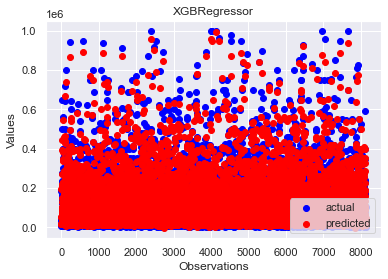

In [243]:
plotGraph(y_train, xgb1.predict(x_train_fs), "XGBRegressor")

<b>Testing data performance</b>

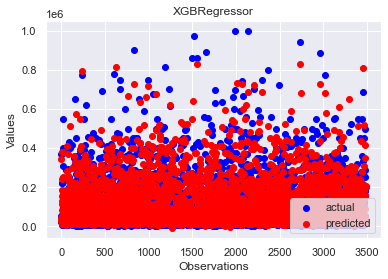

In [244]:
plotGraph(y_test, xgb1.predict(x_test_fs), "XGBRegressor")

After some trial and error, we managed to limit very little the overfitting. The algorithm shows even better results on the testing data.

In [245]:
xgb1 = XGBRegressor(n_estimators=1000, reg_lambda = 37, colsample_bytree = 0.33, learning_rate = 0.1)
xgb1.fit(x_train_fs, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.33,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=37, ...)

In [246]:
xgb1.score(x_train_fs, y_train)

0.8102863681570065

In [247]:
xgb1.score(x_test_fs, y_test)

0.6723443394860822

<b>colsample_bytree = 0.13</b>

In [320]:
xgb1 = XGBRegressor(n_estimators=1000, reg_lambda = 37, colsample_bytree = 0.13, learning_rate = 0.1)
xgb1.fit(x_train_fs, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.13,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=37, ...)

In [321]:
xgb1.score(x_train_fs, y_train)

0.79326414847243

In [322]:
xgb1.score(x_test_fs, y_test)

0.6756681349129545

<b>5000 estimators:</b>

In [338]:
xgb1 = XGBRegressor(n_estimators=5000, reg_lambda = 37, colsample_bytree = 0.13, learning_rate = 0.1)
xgb1.fit(x_train_fs, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.13,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=5000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=37, ...)

In [339]:
xgb1.score(x_train_fs, y_train)

0.8725480740873016

In [340]:
xgb1.score(x_test_fs, y_test)

0.6822343356963371

<b>3000 estimators:</b>

In [345]:
xgb1 = XGBRegressor(n_estimators=3000, reg_lambda = 37, colsample_bytree = 0.13, learning_rate = 0.1)
xgb1.fit(x_train_fs, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.13,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=3000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=37, ...)

In [346]:
xgb1.score(x_train_fs, y_train)

0.8444808615730394

In [347]:
xgb1.score(x_test_fs, y_test)

0.6811886804053711

##### Good base

By increasing the number of estimators we managed to increase the result, by manipulating reg_lambda (L2 regulation) and colsample_bytree (the ratio of the randomly selected features (for the training of each tree) to all the features) we decreased overfitting a little.

We will use the example with 120 estimators as a base to perform a test. 

We have to bear in mind that R_squared is relative method. We now will use the rmse. In this way we will work directly with the absolute value of the residuals.

Let's have a look at what exactly every estimator does (by estimating the result from the two datasets:
validation_0 is the training set, validation_1 is the testing set). The test dataset starts with smaller errors (rmse). Estimators continue to minimize the error. The training dataset shows bigger errors. At the moment when the 107th estimator finishes its work, the result is almost equal. After that the training set continues to minimize the error, but the testing set proceeds with difficulties (this process can be better observed when the estimators are more than 10 thousand, we use only 120 to show the point of overtaking).

In [439]:
xgb1 = XGBRegressor(n_estimators=200, reg_lambda = 37, colsample_bytree = 0.13, learning_rate = 0.1)
xgb1.fit(x_train_fs, y_train, eval_set = [(x_train_fs, y_train), (x_test_fs, y_test)], verbose=True)
# xgb1.fit(x_train_fs, y_train)

[0]	validation_0-rmse:174237.17835	validation_1-rmse:165174.65518
[1]	validation_0-rmse:166853.65613	validation_1-rmse:157769.15266
[2]	validation_0-rmse:160477.47879	validation_1-rmse:151300.18726
[3]	validation_0-rmse:155208.05021	validation_1-rmse:145966.05559
[4]	validation_0-rmse:149413.22667	validation_1-rmse:140395.13247
[5]	validation_0-rmse:145388.96088	validation_1-rmse:136406.96083
[6]	validation_0-rmse:141527.80172	validation_1-rmse:132578.51578
[7]	validation_0-rmse:136932.92885	validation_1-rmse:128432.72565
[8]	validation_0-rmse:133567.37550	validation_1-rmse:125444.97282
[9]	validation_0-rmse:131129.98639	validation_1-rmse:123157.71771
[10]	validation_0-rmse:129500.12914	validation_1-rmse:121548.33635
[11]	validation_0-rmse:127036.36751	validation_1-rmse:119213.74287
[12]	validation_0-rmse:124776.80034	validation_1-rmse:117271.50239
[13]	validation_0-rmse:122994.09314	validation_1-rmse:115866.24224
[14]	validation_0-rmse:121864.69093	validation_1-rmse:114803.45320
[15]	

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.13,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=200, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=37, ...)

In [440]:
xgb1.score(x_train_fs, y_train)

0.7201162054816785

In [441]:
xgb1.score(x_test_fs, y_test)

0.6491403997247606

In [442]:
xgb1 = XGBRegressor(n_estimators=108, reg_lambda = 37, colsample_bytree = 0.13, learning_rate = 0.1)
xgb1.fit(x_train_fs, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.13,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=108, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=37, ...)

In [443]:
xgb1.score(x_train_fs, y_train)

0.6644628133416577

In [444]:
xgb1.score(x_test_fs, y_test)

0.6199001398946471

In [445]:
np.sqrt(mean_squared_error(y_test, xgb1.predict(x_test_fs)))

80843.95636260368

In [446]:
np.sqrt(mean_squared_error(y_train, xgb1.predict(x_train_fs)))

80807.45339544235

We see here, that according to R-squared, there is still some overfitting, but rmse is almost equal. Should we stop here in order to be sure that our model generalizes well? Perhaps, no. Since testing data results improve, there is still hope that our model could be better (following this advice [[3]](#Cell3)). But we take the risk our model to be so good at memorizing results that this overfitting gives better results on the testing data as well. 

<b>Training data performance</b>

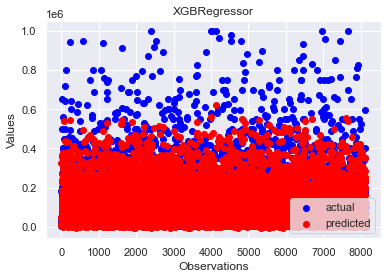

In [447]:
plotGraph(y_train, xgb1.predict(x_train_fs), "XGBRegressor")

<b>Testing data performance</b>

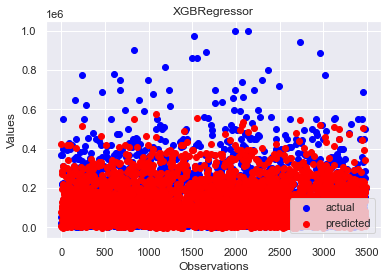

In [448]:
plotGraph(y_test, xgb1.predict(x_test_fs), "XGBRegressor")

Red points look similar in their scatterness (on the training and testing graphs above). If we look at the graph bellow, with 10 000 esitamators, where we witness overfitting, we see the training data's red points cover or are closer to quite a lot distant blue points; this can be seen easily with the red points over 0.60; the more the estimators over 108, the more the red points over 0.6 of the traning data graph.
In the case of overfittig (bellow) the graph of the testing data does show development as well, but we still see holes at places where concentrations of blue points exist. The distant red points seem more chaotic in comparison with the distant red points from the training set. But they start emerging more and more at distant places.

In [478]:
xgb1 = XGBRegressor(n_estimators=10000, reg_lambda = 28, colsample_bytree = 0.13, learning_rate = 0.1)
xgb1.fit(x_train_fs, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.13,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=10000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=28, ...)

In [479]:
xgb1.score(x_train_fs, y_train)

0.917424974582818

In [480]:
xgb1.score(x_test_fs, y_test)

0.6829417057146371

In [481]:
np.sqrt(mean_squared_error(y_test, xgb1.predict(x_test_fs)))

73836.01740911913

In [482]:
np.sqrt(mean_squared_error(y_train, xgb1.predict(x_train_fs)))

40087.17472712584

<b>Training data performance</b>

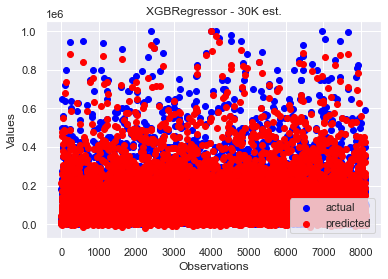

In [483]:
plotGraph(y_train, xgb1.predict(x_train_fs), "XGBRegressor - 30K est.")

<b>Testing data performance</b>

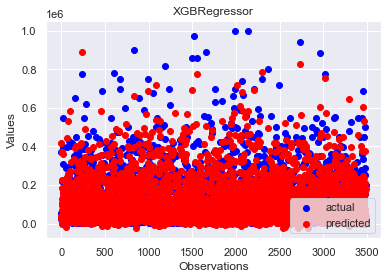

In [484]:
plotGraph(y_test, xgb1.predict(x_test_fs), "XGBRegressor")

<b> With 11 000 estimators </b>

In [492]:
xgb1 = XGBRegressor(n_estimators=11000, reg_lambda = 28, colsample_bytree = 0.13, learning_rate = 0.1)
xgb1.fit(x_train_fs, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.13,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=11000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=28, ...)

In [493]:
xgb1.score(x_train_fs, y_train)

0.9221639849194435

In [494]:
xgb1.score(x_test_fs, y_test)

0.6823098663251126

In [495]:
np.sqrt(mean_squared_error(y_test, xgb1.predict(x_test_fs)))

73909.55165447877

In [496]:
np.sqrt(mean_squared_error(y_train, xgb1.predict(x_train_fs)))

38919.87060974388

<b>Training data performance</b>

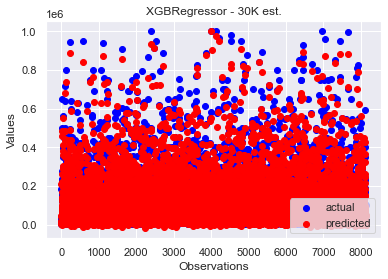

In [497]:
plotGraph(y_train, xgb1.predict(x_train_fs), "XGBRegressor - 30K est.")

<b>Testing data performance</b>

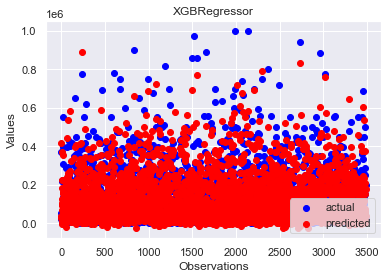

In [498]:
plotGraph(y_test, xgb1.predict(x_test_fs), "XGBRegressor")

The algorithm reaches the peak of the test score around 11 000 estimators. With 12 000 and above the results of the test data start falling.

Even in this case we see many blue points over 0.4 missed by the red ones.

<b> One more chance for the manually curated features</b> 

We tried XGBRegressor with the group that we selected and its results were worse. After some errors and trails, we didn't get much better results that those bellow. 

In [522]:
xgb1 = XGBRegressor(n_estimators=1000, reg_lambda = 37, colsample_bytree = 0.13, learning_rate = 0.1)
xgb1.fit(x_train_without, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.13,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=37, ...)

In [518]:
xgb1.score(x_train_without, y_train)

0.7515033293631843

In [519]:
xgb1.score(x_test_without, y_test)

0.6306437425599143

In [520]:
np.sqrt(mean_squared_error(y_test, xgb1.predict(x_test_without)))

79693.23096958405

In [521]:
np.sqrt(mean_squared_error(y_train, xgb1.predict(x_train_without)))

69541.07152201266

#### Improvement

##### Biggest errors: substancial information is missing

After we have chosen our final model (the one with 11 000 estimators), we will look at the biggest errors that it makes.

In [177]:
xgb_final = XGBRegressor(n_estimators=11000, reg_lambda = 28, colsample_bytree = 0.13, learning_rate = 0.1)
xgb_final.fit(x_train_fs, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.13,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=11000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=28, ...)

In [178]:
xgb_final.score(x_train_fs, y_train)

0.9221639849194435

In [179]:
xgb_final.score(x_test_fs, y_test)

0.6823098663251126

On the graph below we can see that the biggest errors are over 200 000 and below - 200 000.

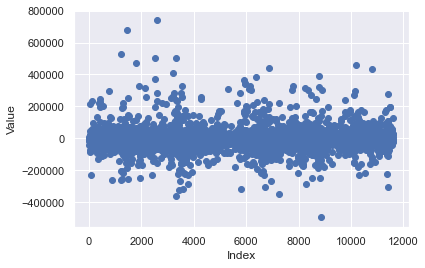

In [160]:
plt.plot(y_test - xgb_final.predict(x_test_fs), marker='o',linestyle='')
plt.xlabel('Index')
plt.ylabel('Value')
plt.show()

We are going to create a table with the errors and have a look at the first three.

In [180]:
errors_table = pd.DataFrame({
    'y_test': y_test,
    'predicted': xgb_final.predict(x_test_fs),
    'error': y_test - xgb_final.predict(x_test_fs),
    'abs_error': abs(y_test - xgb_final.predict(x_test_fs))
})

In [181]:
#Let's sort it
errors_table = errors_table.sort_values('abs_error', ascending=False)

In [163]:
# whole_errors_table = errors_table.merge(x_test, how="left", left_index=True, right_index=True)

We can conclude on the base of what we see, that the main problem here is the expensive properties. More expensive than our algorithm can imagine (probably because they are not within its means). ;) 

Let's merge this table with the whole one in order to see the big picture.

In [182]:
errors_whole_table = errors_table.merge(all_houses_columns, how='left', left_index=True, right_index = True)

In [183]:
errors_25 = errors_whole_table.head(25)

In [184]:
errors_25.head(5)

,y_test,predicted,error,abs_error,income,price,floors,size,yard,sewerage,...,pool,gated_community,water_well,solar_panels,fireplace,residential_area,settlement,region,kind_of_residential_area,kind_of_settlement
2582,975000.0,232221.31250,742778.68750,742778.68750,1325,975000.0,1,922.0,0.0,no,...,no,no,no,no,no,0,град Сливен,област Сливен,0,city
1459,999800.0,318697.37500,681102.62500,681102.62500,1538,999800.0,1,565.0,0.0,no,...,no,no,no,no,no,0,село Марково,област Пловдив,0,village
1219,815000.0,286707.59375,528292.40625,528292.40625,1538,815000.0,2,200.0,200.0,no,...,no,no,no,no,no,център,град Пловдив,област Пловдив,center,city
3333,749000.0,243082.34375,505917.65625,505917.65625,2423,749000.0,3,210.0,328.0,no,...,no,no,no,no,no,Лозенец,град София,област София,neighbourhood,capital
2519,700000.0,199916.90625,500083.09375,500083.09375,1325,700000.0,3,437.0,311.0,no,...,no,no,no,no,no,център,град Сливен,област Сливен,center,city


Now we are going to use shap to interpret the model and its errors.

In [167]:
#We will take the names of the features that SelectKBest uses
cols = fs.get_support(indices=True)
x_test_fs_with_features_name = x_test_minmax.iloc[:,cols]

In [168]:
x_test_fs_with_features_name.head(5)

,income,floors,size,yard,sewerage_yes,power_yes,water_supply_yes,garage_yes,detached_house_yes,heating_system_yes,...,kind_of_residential_area_area close to settlement,kind_of_residential_area_center,kind_of_residential_area_holiday homes zone,kind_of_residential_area_neighbourhood,kind_of_settlement_capital,kind_of_settlement_city,kind_of_settlement_other,kind_of_settlement_resort,kind_of_settlement_town,kind_of_settlement_village
5062,0.206026,0.000000,0.066327,0.015385,0,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,1
8704,0.350163,0.666667,0.517347,0.014400,1,1,1,1,1,0,...,1,0,0,0,0,1,0,0,0,0
7204,0.176710,0.333333,0.051020,0.007769,0,1,1,1,0,0,...,0,0,0,1,0,0,0,0,0,1
4265,0.030945,0.666667,0.285714,0.005077,0,1,1,1,0,1,...,0,0,0,1,0,1,0,0,0,0
6605,0.176710,0.666667,0.265306,0.006154,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [169]:
exp = shap.TreeExplainer(xgb_final)   #Tree Explainer
shap_values = exp.shap_values(x_test_fs_with_features_name)  #Calculate Shap Values
shap.initjs()

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


We should have the features` names inside the table. Therefore, we had to take them from SelectKBest.

Overall, for the testing data, the most important feature according to our model is the size. Followed by income, the kind of setllement: village or city. Yard, heating system and the region Sofia are also among the most important ones.

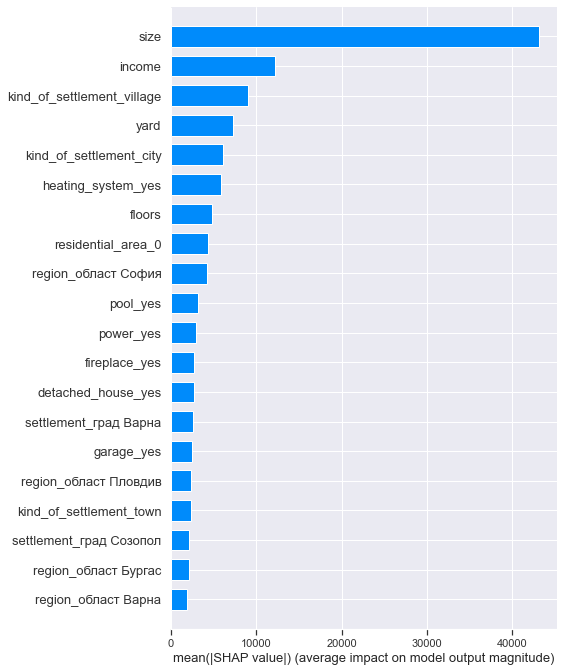

In [170]:
shap.summary_plot(shap_values, x_test_fs_with_features_name, plot_type="bar")

We will see the indices of the houses for which our model was very wrong.

In [171]:
errors_25.index

Int64Index([ 2582,  1459,  1219,  3333,  2519,  8846,  1783, 10180,  6875,
            10810,  3207,  8776,  6369,  2517,  5910,  3328,  7255,  5961,
             5958,  1915,  7795,  6134,  3543,  3431,  3595],
           dtype='int64')

Now, let's investigate the house with the biggest error in price. 

In [172]:
errors_whole_table.loc[2582]

y_test                           975000.0
predicted                     232221.3125
error                         742778.6875
abs_error                     742778.6875
income                               1325
price                            975000.0
floors                                  1
size                                922.0
yard                                  0.0
sewerage                               no
power                                  no
water_supply                           no
garage                                 no
view                                   no
detached_house                         no
bbq_gazebo                             no
heating_system                         no
pool                                   no
gated_community                        no
water_well                             no
solar_panels                           no
fireplace                              no
residential_area                        0
settlement                    град

According to XGBRegressor the most important features for this house are visible on the graph below.

In [173]:
explainer = shap.Explainer(xgb_final, x_test_fs_with_features_name)
shap_values = explainer(x_test_fs_with_features_name)

100%|===================| 3482/3486 [10:39<00:00]        

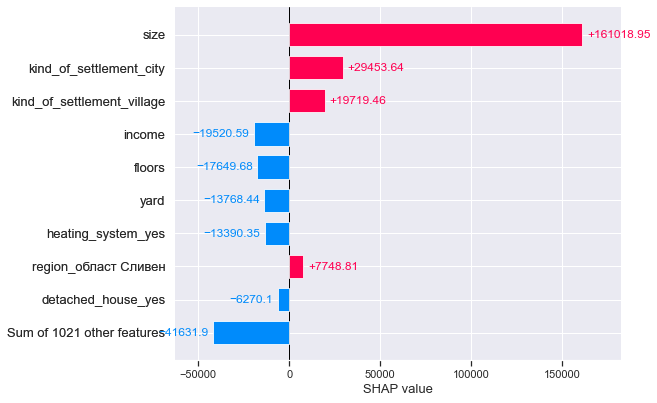

In [174]:
shap.plots.bar(shap_values[x_test_fs_with_features_name.index.get_indexer([2582])[0]])

Here we see the most important feature - the size - to increase the price. The fact that Sliven is a city and is not a village does it so as well. The income though is lower there and that decreases the price, according to our model. The floors (1), the yard (no yard), the lack of a heating system, and the lack of information that this is a detached_house also draw the price down.

This is the link to the house: [[4]](#Cell4). We see (in the text) that it has 4 floors, a yard, a pool, and a fireplace. The size actually is 238 sqr.m. All this information is missing on the top of the site with concise information (the floors there are only 1). 

We saw (on the graph earlier) that all these features play a role in the prediction. So, now let's see with the information we already know what will be the prediction of our model.

In [175]:
all_house_features.columns

Index(['income', 'floors', 'size', 'yard', 'sewerage', 'power', 'water_supply',
       'garage', 'view', 'detached_house', 'bbq_gazebo', 'heating_system',
       'pool', 'gated_community', 'water_well', 'solar_panels', 'fireplace',
       'residential_area', 'settlement', 'region', 'kind_of_residential_area',
       'kind_of_settlement'],
      dtype='object')

In [176]:
edited_1st = [[1325, 4, 238, 684, 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'no', 'no', 'yes', 'yes', '0', 'град Сливен', 'област Сливен', '0', 'city']]

In [177]:
edited_df = pd.DataFrame(edited_1st, columns=all_house_features.columns)

In [178]:
edited_df

,income,floors,size,yard,sewerage,power,water_supply,garage,view,detached_house,...,pool,gated_community,water_well,solar_panels,fireplace,residential_area,settlement,region,kind_of_residential_area,kind_of_settlement
0,1325,4,238,684,yes,yes,yes,yes,yes,yes,...,yes,no,no,yes,yes,0,град Сливен,област Сливен,0,city


In [179]:
#After filling in the initial columns we should get the get_dummies features specific for this row and 
#fill the other get_dummies features with zeros
edited_df = pd.get_dummies(edited_df)
edited_df = edited_df.reindex(columns = x_test_minmax.columns, fill_value=0)

In [180]:
edited_df

,income,floors,size,yard,sewerage_yes,power_yes,water_supply_yes,garage_yes,detached_house_yes,heating_system_yes,...,kind_of_residential_area_area close to settlement,kind_of_residential_area_center,kind_of_residential_area_holiday homes zone,kind_of_residential_area_neighbourhood,kind_of_settlement_capital,kind_of_settlement_city,kind_of_settlement_other,kind_of_settlement_resort,kind_of_settlement_town,kind_of_settlement_village
0,1325,4,238,684,1,1,1,1,1,1,...,0,0,0,0,0,1,0,0,0,0


In [181]:
edited_df.iloc[:, 0:4]

,income,floors,size,yard
0,1325,4,238,684


In [182]:
#Let's scale the numeric columns
edited_df.iloc[:, 0:4] = scaler_minmax.transform(edited_df.iloc[:, 0:4])

In [183]:
#Take back the feature names
cols = fs.get_support(indices=True)
saved_cols = edited_df.iloc[:,cols]
edited_df = fs.transform(edited_df)
edited_df = saved_cols

In [184]:
#Check
edited_df

,income,floors,size,yard,sewerage_yes,power_yes,water_supply_yes,garage_yes,detached_house_yes,heating_system_yes,...,kind_of_residential_area_area close to settlement,kind_of_residential_area_center,kind_of_residential_area_holiday homes zone,kind_of_residential_area_neighbourhood,kind_of_settlement_capital,kind_of_settlement_city,kind_of_settlement_other,kind_of_settlement_resort,kind_of_settlement_town,kind_of_settlement_village
0,0.105863,1.0,0.222449,0.010523,1,1,1,1,1,1,...,0,0,0,0,0,1,0,0,0,0


In [185]:
xgb_final.predict(edited_df)

array([350116.12], dtype=float32)

The predicted price will be 350 116 EUR, or about 117 895 EUR more. There is still a large gap between the predicted and the actual price (of 975 000 EUR). We are not quite sure why the price here is so high. Real estate agents should be consulted for such cases. The house has a sauna and 10 bedrooms. These two advantages probably play some role as well.

In [186]:
expl = shap.Explainer(xgb_final)
shap_values_edited_df_a = expl(edited_df)
shap.initjs()

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


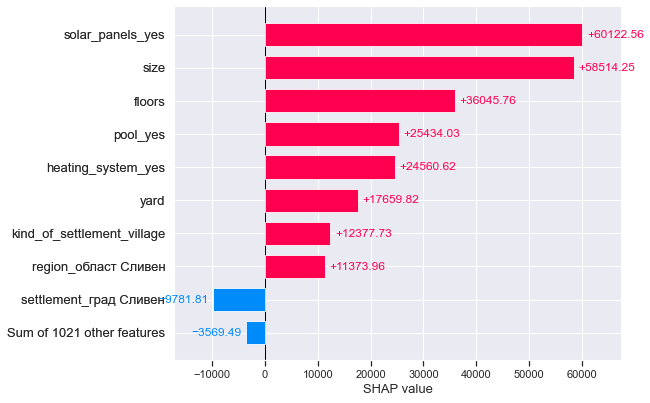

In [187]:
shap.plots.bar(shap_values_edited_df_a[0])

We see a very different picture here - the main features are the solar panels, the size, the floors (the maximum - 4), the pool, the heating system, the yard, and the fact that Sliven is not a village. All these features raise the price. 

There are some features, though, that cannot be caught by our algorithm because they do not exist in the data. The house has a lot of bedrooms, as well as a sauna.

The missing data, that we filled in, and these missing features can be found in the text. So, if we want better results we <b>should include more data extraction from the text of the listing</b>. 

We see that the 10 bedrooms in the house are mentioned in the header.

Sometimes <b>important details can be found in the title of the listing</b>. This is something that we didn't notice when we were building the spider. But it should be included in addition to the text extraction.

Therefore, more features should be included in the raw table like an elevator, a sauna, and the number of bedrooms. Probably they will increase the price. The case with the bedrooms though is tricky since it will be correlated to some degree with the size of the house (as it is in this study [[9]](#Cell9))

It seems that our model copes with the basic houses but not with those with extra advantages.

In [188]:
errors_whole_table.loc[1459]

y_test                            999800.0
predicted                       318697.375
error                           681102.625
abs_error                       681102.625
income                                1538
price                             999800.0
floors                                   1
size                                 565.0
yard                                   0.0
sewerage                                no
power                                   no
water_supply                            no
garage                                  no
view                                    no
detached_house                          no
bbq_gazebo                              no
heating_system                         yes
pool                                    no
gated_community                         no
water_well                              no
solar_panels                            no
fireplace                               no
residential_area                         0
settlement 

We see the same problem with the second house (with the second biggest error in the price). The link to the listing: [[5]](#Cell5). We understand only from the text that the house has 4 floors, a bigger number of bedrooms (and options for more), a heating system, a yard, a pool, a BBQ, and a view.  

In [189]:
errors_whole_table.loc[1219]

y_test                            815000.0
predicted                     286707.59375
error                         528292.40625
abs_error                     528292.40625
income                                1538
price                             815000.0
floors                                   2
size                                 200.0
yard                                 200.0
sewerage                                no
power                                  yes
water_supply                           yes
garage                                  no
view                                    no
detached_house                         yes
bbq_gazebo                              no
heating_system                          no
pool                                    no
gated_community                         no
water_well                              no
solar_panels                            no
fireplace                               no
residential_area                    център
settlement 

This is the link to the third house: [[6]](#Cell6). It is not just a central place, but quite an attractive one (if we look at the whole list of the Plovdiv houses in the center, the prices are much lower: [[7]](#Cell7). 

So, this house is a cheaper representative of those that we eliminated earlier because their price is too connected to the specifics of their location. 

##### Global problem

As we have already mentioned our model has a big problem with ... the big prices. Since we know that our main feature is the size of the property, then our model is likely to underestimate the bigger houses. Probably because the smaller houses with smaller sizes are more. Let's see.

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


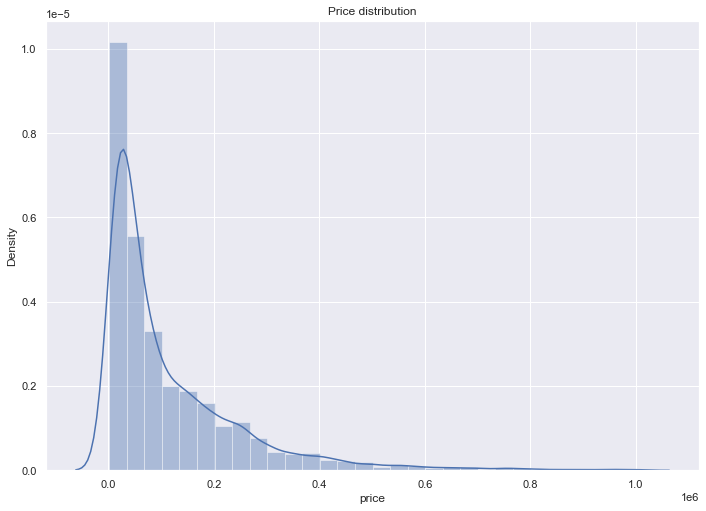

In [190]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.distplot(all_house_target, bins=30)
plt.title('Price distribution')
plt.show()

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


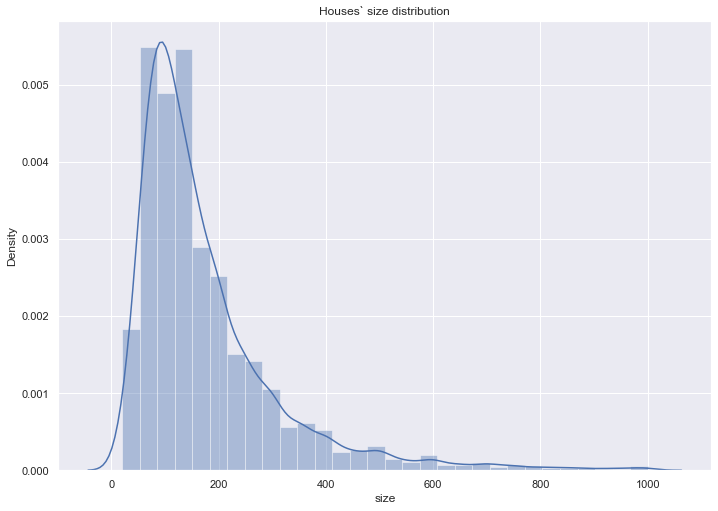

In [191]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.distplot(all_houses['size'], bins=30)
plt.title('Houses` size distribution')
plt.show()

We have positive-skew distributions (with long tail to the bigger numbers).

Let's check for heteroskedasticity.

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.371
Model:                            OLS   Adj. R-squared:                  0.371
Method:                 Least Squares   F-statistic:                     6857.
Date:                Wed, 07 Dec 2022   Prob (F-statistic):               0.00
Time:                        13:28:45   Log-Likelihood:            -1.5122e+05
No. Observations:               11619   AIC:                         3.025e+05
Df Residuals:                   11617   BIC:                         3.025e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   8924.1607   1641.221      5.438      0.0

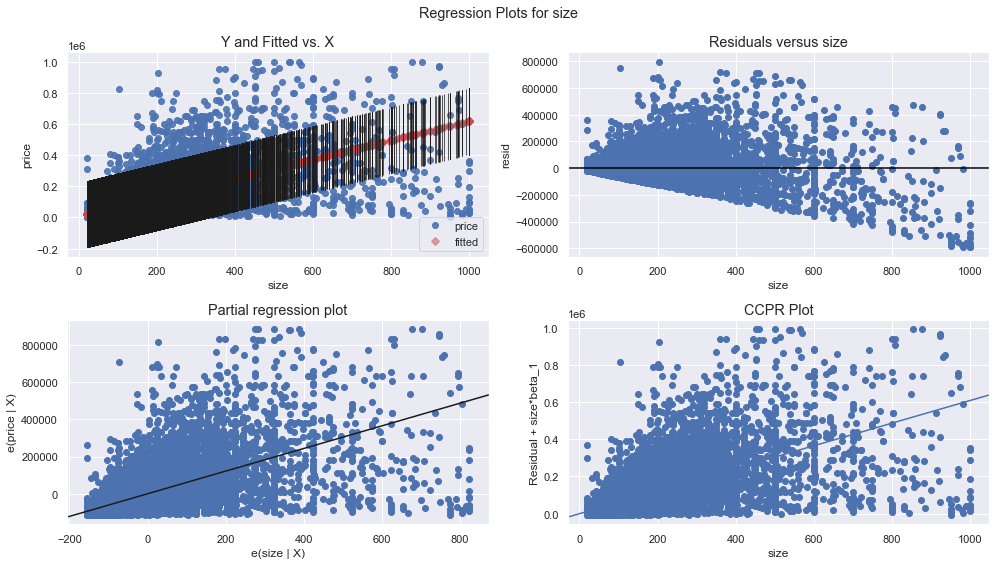

In [192]:
# fit multi linear regression model
multi_model = ols('price ~ size', data=all_houses).fit()
  
# display model summary
print(multi_model.summary())
  
# modify figure size
fig = plt.figure(figsize=(14, 8))
  
# creating regression plots
fig = sm.graphics.plot_regress_exog(multi_model, 'size', fig=fig)

We see on the upper right graph a cone shape that indicates the presence of heteroskedasticity. As the size goes up, the residuals go further.

The typical approach in this situation is to use the log of the target variable (at the place of the target variable), so that its variance gets smaller.

In [185]:
xgb_final = XGBRegressor(n_estimators=11000, reg_lambda = 28, colsample_bytree = 0.13, learning_rate = 0.1)
xgb_final.fit(x_train_fs, np.log(y_train))

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.13,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=11000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=28, ...)

In [187]:
xgb_final.score(x_train_fs, np.log(y_train))

0.8614425936918799

In [188]:
xgb_final.score(x_test_fs, np.log(y_test))

0.7398588986431291

In [189]:
np.sqrt(mean_squared_error(np.log(y_test), xgb_final.predict(x_test_fs)))

0.5961986164011723

In [190]:
np.sqrt(mean_squared_error(np.log(y_train), xgb_final.predict(x_train_fs)))

0.4455431677798093

We see that our model got better. Its score is almost 0.74. If our spider became more precise and there was a function that extracts richer information from the text field of the website, the results would improve even more.

Now let's combine our best algorithm with the Ransac inliers. We will remind you that our RANSAC accuracy (with inliers) was 0.957. We will try to improve these results.

In [159]:
ransac_xg = RANSACRegressor(
    base_estimator=XGBRegressor(n_estimators=11000, reg_lambda = 28, colsample_bytree = 0.13, learning_rate = 0.1),
    min_samples=0.55, 
)
ransac_xg.fit(x_train_fs, y_train)


KeyboardInterrupt



In [ ]:
print(f"R-square score train: {ransac_xg.score(x_train_fs[ransac_xg.inlier_mask_], y_train[ransac_xg.inlier_mask_])}")

<b> With Test Dataset </b>

In [195]:
ransac_xg.fit(x_test_fs, y_test)

RANSACRegressor(base_estimator=XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.13,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None, gamma=None,
                                            gpu_id=None, grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.1, max_bin=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=11000, n_jobs=None,
                                            num_parallel_tree=None,
                                            predictor=None, random_state=None,
                                            reg_alpha=None, reg_lambda=28, ...),
                min_samples=0.55)

In [197]:
print(f"R-square score test: {ransac_xg.score(x_test_fs[ransac_xg.inlier_mask_], y_test[ransac_xg.inlier_mask_])}")

R-square score test: 0.9878907941269454


We got even better results. Let's save the model.

In [200]:
filename = 'ransac_xg_boost.sav'
pickle.dump(ransac_xg, open(filename, 'wb'))

Now the model will be loaded again and checked if it will provide the same result on the testing dataset.

In [160]:
loaded_model = pickle.load(open('ransac_xg_boost.sav', 'rb'))
result = loaded_model.score(x_test_fs[loaded_model.inlier_mask_], y_test[loaded_model.inlier_mask_])
print(result)

0.9878907941269454


In [161]:
print(f"R-square score test: {loaded_model.score(x_test_fs, y_test)}")

R-square score test: 0.8122005054564947


We see that even if we don't include only the inliers, RANSAC led to better results.

Our model is saved and loaded successfully.

#### Final test

Now let's see if we reached our goal. Will we find good deals?

We want to find a house about 200 sqr.m. with 2 000 sqr.m. yard in the region of Plovdiv. Let's choose the most expensive village in the region - Markovo.

In [163]:
dreamed_house = [[1538, 1, 200, 2000, 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', '0', 'село Марково', 'област Пловдив', '0', 'village']]

In [164]:
dreamed_house_pd = pd.DataFrame(dreamed_house, columns=all_house_features.columns)

In [165]:
dreamed_house_pd

,income,floors,size,yard,sewerage,power,water_supply,garage,view,detached_house,...,pool,gated_community,water_well,solar_panels,fireplace,residential_area,settlement,region,kind_of_residential_area,kind_of_settlement
0,1538,1,200,2000,no,no,no,no,no,no,...,no,no,no,no,no,0,село Марково,област Пловдив,0,village


In [166]:
#After filling in the initial columns we should get the get_dummies features specific for this row and 
#fill the other get_dummies features with zeros
dreamed_house_pd = pd.get_dummies(dreamed_house_pd)
dreamed_house_pd = dreamed_house_pd.reindex(columns = x_test_minmax.columns, fill_value=0)

In [167]:
dreamed_house_pd

,income,floors,size,yard,sewerage_yes,power_yes,water_supply_yes,garage_yes,detached_house_yes,heating_system_yes,...,kind_of_residential_area_area close to settlement,kind_of_residential_area_center,kind_of_residential_area_holiday homes zone,kind_of_residential_area_neighbourhood,kind_of_settlement_capital,kind_of_settlement_city,kind_of_settlement_other,kind_of_settlement_resort,kind_of_settlement_town,kind_of_settlement_village
0,1538,1,200,2000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [168]:
dreamed_house_pd.iloc[:, 0:4]

,income,floors,size,yard
0,1538,1,200,2000


In [169]:
#Let's scale the numeric columns
dreamed_house_pd.iloc[:, 0:4] = scaler_minmax.transform(dreamed_house_pd.iloc[:, 0:4])

In [170]:
#Take back the feature names
cols = fs.get_support(indices=True)
saved_cols = dreamed_house_pd.iloc[:,cols]
dreamed_house_pd = fs.transform(dreamed_house_pd)
dreamed_house_pd = saved_cols

In [171]:
#Check
dreamed_house_pd

,income,floors,size,yard,sewerage_yes,power_yes,water_supply_yes,garage_yes,detached_house_yes,heating_system_yes,...,kind_of_residential_area_area close to settlement,kind_of_residential_area_center,kind_of_residential_area_holiday homes zone,kind_of_residential_area_neighbourhood,kind_of_settlement_capital,kind_of_settlement_city,kind_of_settlement_other,kind_of_settlement_resort,kind_of_settlement_town,kind_of_settlement_village
0,0.279316,0.0,0.183673,0.030769,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [212]:
final_price = xgb_final.predict(dreamed_house_pd)
print(np.exp(final_price))

[160792.39]


So, according to XG_Boost (log of the target variable), the house will cost 160 792.39 EUR. 

According to the combination of the two models, it will cost:

In [172]:
final_price_ransac_xg = loaded_model.predict(dreamed_house_pd)
print(final_price_ransac_xg)

[219529.61]


X has feature names, but RANSACRegressor was fitted without feature names


Let's see if there are houses like this one with a smaller price (even less than 160 792 EUR) and underestimated by the algorithm.

We will create a table with the errors again (this time the difference will be between the predicted cost by the combination and the real price). 

In [173]:
errors_table = pd.DataFrame({
    'y_test': y_test,
    'predicted': loaded_model.predict(x_test_fs),
    'error': y_test - loaded_model.predict(x_test_fs),
    'abs_error': abs(y_test - loaded_model.predict(x_test_fs))
})

In [174]:
#Let's sort it
errors_table = errors_table.sort_values('abs_error', ascending=False)

In [175]:
errors_whole_table = errors_table.merge(all_houses_columns, how='left', left_index=True, right_index = True)

In [176]:
errors_whole_table[(errors_whole_table['price'] < 160792) & (errors_whole_table['error'] < -50000) & (errors_whole_table['settlement'] == 'село Марково') & (errors_whole_table['size'] >= 200)]

,y_test,predicted,error,abs_error,income,price,floors,size,yard,sewerage,...,pool,gated_community,water_well,solar_panels,fireplace,residential_area,settlement,region,kind_of_residential_area,kind_of_settlement


We don't see big mistakes as those in the error table of XGBoost (with errors more than 50 000 EUR).

In [177]:
errors_whole_table[(errors_whole_table['price'] < 160792) & (errors_whole_table['error'] < -30000) & (errors_whole_table['settlement'] == 'село Марково') & (errors_whole_table['size'] >= 200)]

,y_test,predicted,error,abs_error,income,price,floors,size,yard,sewerage,...,pool,gated_community,water_well,solar_panels,fireplace,residential_area,settlement,region,kind_of_residential_area,kind_of_settlement
1498,95999.0,136211.203125,-40212.203125,40212.203125,1538,95999.0,2,400.0,340.0,no,...,no,no,no,no,no,0,село Марково,област Пловдив,0,village


In [178]:
#Find the house in the all_houses dataset, so that we can have a look at the url of its listing
all_houses[(all_houses['price'] == 95999.0) & (errors_whole_table['settlement'] == 'село Марково')]

Boolean Series key will be reindexed to match DataFrame index.


,price,floors,size,yard,sewerage,power,water_supply,garage,view,detached_house,...,water_well,solar_panels,fireplace,text,url,residential_area,settlement,region,kind_of_residential_area,kind_of_settlement
1508,95999.0,2,400.0,340.0,no,no,no,no,no,no,...,no,no,no,\n\t\t\t\tоф.11610 Предлагаме Ви да закупите и...,https://www.alo.bg/7992415,0,село Марково,област Пловдив,0,village


We didn't expect to find anything with such high criteria (less than the lower price of the XGBoost model and error, higher than 30 000 EUR), but it turned out to exist. Let's see the house: [[8]](#Cell8).

Well, let's say that this method is promising but not ideal. This house needs major repairs. 

Even for our most successful model, it was quite a difficult task. Its error is about 40 000 EUR. It is possible this house really be a good deal.

We can loosen the filters or try nother settlement. But this is a question of the way we search than a question of model and code. It is out of this project's scope.

How can we create a group of houses that meet certain criteria? For example - we want to track homes of a similar size to the one above whose prices are lower than the expected price. First, let's try with the lowest predicted price.

In [179]:
errors_whole_table[(errors_whole_table['price'] < 160792) & (errors_whole_table['settlement'] == 'село Марково') & (errors_whole_table['size'] >= 200)]

,y_test,predicted,error,abs_error,income,price,floors,size,yard,sewerage,...,pool,gated_community,water_well,solar_panels,fireplace,residential_area,settlement,region,kind_of_residential_area,kind_of_settlement
1498,95999.0,136211.203125,-40212.203125,40212.203125,1538,95999.0,2,400.0,340.0,no,...,no,no,no,no,no,0,село Марково,област Пловдив,0,village


Unfortunately, there is only one house under the estimated price by XGBoost (and probably a kind of outlier due to its condition).  

We will use the closest to the real market - the one that the combination of RANSAC and XGBoost predicted.

In [186]:
errors_whole_table[(errors_whole_table['price'] < 219529.61) & (errors_whole_table['settlement'] == 'село Марково') & (errors_whole_table['size'] >= 200)]

,y_test,predicted,error,abs_error,income,price,floors,size,yard,sewerage,...,pool,gated_community,water_well,solar_panels,fireplace,residential_area,settlement,region,kind_of_residential_area,kind_of_settlement
1498,95999.0,136211.203125,-40212.203125,40212.203125,1538,95999.0,2,400.0,340.0,no,...,no,no,no,no,no,0,село Марково,област Пловдив,0,village
1457,190000.0,198325.968750,-8325.968750,8325.968750,1538,190000.0,2,235.0,316.0,no,...,no,no,no,no,no,0,село Марково,област Пловдив,0,village
1470,216300.0,210621.515625,5678.484375,5678.484375,1538,216300.0,2,210.0,380.0,yes,...,no,no,no,no,no,0,село Марково,област Пловдив,0,village
1533,189999.0,192636.562500,-2637.562500,2637.562500,1538,189999.0,2,210.0,100.0,no,...,no,no,no,no,no,0,село Марково,област Пловдив,0,village


We see that there are more houses with costs around the predicted price by the combination of the algorithms. It seems that XG Boost (alone) took into account the outlier - the house for renovation (95999 EUR), but RANSAC eliminated it. This led to higher estimates and, obviously, to more accurate predictions.

Now we have a group of houses like the one we searched for. This group's cost is located under the predicted price of 219529.61. Our model estimated higher prices for three of the houses. Their listing probably would be interesting for a potential buyer.

After creating this group we can monitor if the houses disappear (there is a demand), stay for a long time (no high demand and good opportunity for negotiations with the seller), or if more houses appear (there is intensive construction and a chance the prices to fall in the future). Of course, under the condition that this project is live and is updated periodically.

***********

## In conclusion

The greatest challenge for the project was reducing the data. It was done on the base of the linearity (proportionality) between the features and the target. After that, the data was tested with different algorithms. The winners, the combination between RANSAC and XGBRegressor, showed very high results - almost 0.99 accuracy with the inliers and 0.81 with the whole test dataset. 

We don't think that this is the only approach. The sky is the limit. 

Every algorithm can be tested with different SelectKBest feature numbers. We saw earlier that if we want to leave only the biggest ones, we will use less than 20.   

The data also can be provided chunk by chunk for algorithms testing (that we performed with RandomizedSearchCV). In this way, we won't add bias like what we actually did with the feature selection.  

We still have missing variables like the condition of homes, their age, the attractiveness of their settlement and residential area, the distance of the settlement from the regional center, and many advantages of the properties like the number of bedrooms, sauna, elevator, etc. But even with the data from our spider, we can grasp a picture of the houses for sale.  

If the whole project is launched periodically, users can find good offers. According to this study (2-3 p. [[9]](#Cell9)), some prices are good because of two reasons: 

1. The house has remained published in the listing for some time, during which
its value has risen (because of global or local trends) but the seller has not updated its value. 
2. The asset is to be sold fast, for example, if the seller needs the money.

Our model and filters allow finding exactly such listings.

But the users of this project can monitor the market dynamics. For example, they can track the houses that meet certain criteria and whether their number increases, decreases or doesn't change (there is intensive construction, high demand, or neither of the two). This can help them decide whether it is the right time to buy a house.

### References

<a id='Cell1'>[1]</a> https://www.alo.bg/7853319. Accessed 23 November 2022.

<a id='Cell2'>[2]</a> Статистически райони; област. https://www.nsi.bg/bg/content/3930/%D1%81%D1%82%D0%B0%D1%82%D0%B8%D1%81%D1%82%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%B8-%D1%80%D0%B0%D0%B9%D0%BE%D0%BD%D0%B8-%D0%BE%D0%B1%D0%BB%D0%B0%D1%81%D1%82. Accessed 25 November 2022.

<a id='Cell3'>[3]</a> Jason Brownlee. How to Identify Overfitting Machine Learning Models in Scikit-Learn. https://machinelearningmastery.com/overfitting-machine-learning-models/. Accessed 24 November 2022.

<a id='Cell4'>[4]</a> https://www.alo.bg/6875412. Accessed 25 November 2022.

<a id='Cell5'>[5]</a> https://www.alo.bg/8281371. Accessed 25 November 2022.

<a id='Cell6'>[6]</a> https://www.alo.bg/8072297. Accessed 25 November 2022.

<a id='Cell7'>[7]</a> https://www.alo.bg/obiavi/imoti-prodajbi/kashti-vili/?region_id=16&location_ids=3333&section_ids=318). Accessed 25 November 2022.

<a id='Cell8'>[8]</a> <a id='Cell6'>[6]</a> https://www.alo.bg/7992415. Accessed 25 November 2022.

<a id='Cell9'>[9]</a> Alejandro Baldominos, Iván Blanco, Antonio José Moreno, Rubén Iturrarte, Óscar Bernárdez, Carlos Afonso. Identifying Real Estate Opportunities Using
Machine Learning. https://arxiv.org/pdf/1809.04933.pdf. Accessed 25 November 2022.